<a href="https://colab.research.google.com/github/Casta-utp/AG-vs-ACO-CBGA/blob/main/Taller_AG_vs_ACO_Santiago_Casta%C3%B1eda_P%C3%A9rez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller (Notebook): Comparación y afinamiento de GA vs ACO en el TSP (TSPLIB)  
## Extensión PLUS: Algoritmo Genético de Chu–Beasley (CBGA)

Este cuaderno guía un mini-proyecto tipo **investigación aplicada** para comparar y afinar:

- 🧬 **Algoritmo Genético clásico (GA)**
- 🐜 **Ant Colony Optimization (ACO)**
- ➕ **Chu–Beasley Genetic Algorithm (CBGA)**

**Regla del taller:** este cuaderno **no incluye código de referencia** (solo estructura, criterios y plantillas).  
Los estudiantes deben implementar los algoritmos y reportar resultados con metodología experimental.

## Requisitos

- Python 3.10+
- Librerías sugeridas: `tsplib95`, `numpy`, `matplotlib`
- Instancias TSPLIB recomendadas: `eil51`, `berlin52`, `att48`, `st70` (o equivalentes)

> Nota: Si tu entorno no tiene TSPLIB a la mano, el docente puede proveer los `.tsp` o una carpeta `data/`.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Objetivos del taller

1. Implementar GA, ACO y CBGA para TSP usando instancias TSPLIB.
2. Definir una metodología experimental **justa** (mismo presupuesto computacional).
3. Medir y comparar desempeño: **distancia**, **tiempo**, **convergencia**, **estabilidad** (variabilidad).
4. Realizar **tuning** (afinamiento) de hiperparámetros para mejorar resultados.
5. Concluir **cuál es “mejor”** bajo distintos criterios (no existe un único ganador universal).

## ¿Qué significa “mejor”?

En este taller, “mejor” se define con **múltiples criterios**:

- **Calidad:** menor longitud de tour (distancia).
- **Rapidez:** menor tiempo para lograr buena calidad.
- **Estabilidad:** baja variación entre corridas (desviación estándar pequeña).
- **Escalabilidad:** se degrada menos al aumentar el tamaño del problema.

El reporte final debe explicar **qué criterio prioriza** tu conclusión.

---

# 1) Planteamiento del problema (TSP) y TSPLIB

El **TSP** busca un ciclo Hamiltoniano de costo mínimo.

### Tareas
- Elegir 2–3 instancias TSPLIB (al menos una de ~50 nodos y otra más grande).
- Registrar si cada instancia tiene óptimo conocido (cuando esté disponible).

In [2]:
# Configurar rutas y cargar instancias TSPLIB
# - Define una lista de paths de archivos .tsp (por ejemplo: data/berlin52.tsp).
# - Carga cada instancia, extrae dimensión y (si existe) el óptimo conocido.
# - Define una función para evaluar la longitud de un tour.

## Librerias

In [3]:
!pip install tsplib95

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.1.1
    Uninstalling wrapt-2.1.1:
      Successfully uninstalled wrapt-2.1.1
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.6.1
    Uninstalling networkx-3.6.1:
      Successfully uninstalled networkx-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.35.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
momepy 0.11.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
spopt 0.7.0 requires

In [4]:
import tsplib95
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import mannwhitneyu

## 1. Carga de Instancias y Funciones de Evaluación

In [5]:
TSP_INSTANCES = {
    "berlin52": "TSP/berlin52.tsp",
    "eil51": "TSP/eil51.tsp",
    "att48": "TSP/att48.tsp",
    "st70": "TSP/st70.tsp"
}

KNOWN_OPTIMA = {"berlin52": 7542, "eil51": 426, "att48": 10628, "st70": 675}

def load_problem(tsp_name):
    """Carga una instancia de problema TSP desde un archivo .tsp."""
    path = TSP_INSTANCES.get(tsp_name)
    if not path or not os.path.exists(path):
        print(f"Archivo no encontrado para '{tsp_name}' en la ruta '{path}'.")
        print("Asegúrate de que el archivo .tsp exista en el directorio 'TSP/'.")
        return None
    problem = tsplib95.load(path)
    return problem

def get_distance_matrix(problem):
    """Obtiene la matriz de distancias de un problema cargado."""
    if problem.is_explicit():
        # La matriz de distancias está dada explícitamente
        nodes = list(problem.get_nodes())
        dim = len(nodes)
        dist_matrix = np.zeros((dim, dim))
        for i in range(dim):
            for j in range(dim):
                dist_matrix[i, j] = problem.get_weight(nodes[i], nodes[j])
        return dist_matrix
    elif problem.is_full_matrix():
        # La matriz de distancias está completa en el archivo
        return np.array(problem.edge_weights)
    else:
        # Calcular distancias euclidianas desde las coordenadas
        coords = np.array([problem.node_coords[i] for i in sorted(problem.node_coords.keys())])
        dist_matrix = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2)
        return dist_matrix

def calculate_tour_length(tour, dist_matrix):
    """Calcula la longitud total de un tour dado."""
    total_distance = 0
    num_cities = len(tour)
    for i in range(num_cities):
        # Distancia del nodo actual al siguiente (con ciclo de vuelta al inicio)
        start_node = tour[i] - 1  # Ajuste de índice (TSPLIB es 1-based)
        end_node = tour[(i + 1) % num_cities] - 1 # Ajuste de índice
        total_distance += dist_matrix[start_node, end_node]
    return total_distance

## 2. Ejemplo de uso

In [6]:
if __name__ == '__main__':
    # Selecciona una instancia para probar
    instance_name = "berlin52"
    problem = load_problem(instance_name)

    if problem:
        print(f"Instancia cargada: {problem.name}")
        print(f"Dimension: {problem.dimension}")
        print(f"Tipo de peso de borde: {problem.edge_weight_type}")

        # Intentar obtener el óptimo conocido si está en los comentarios del archivo
        optimal_tour_length = problem.comment.split('Optimal value: ')[-1].split(')')[0]
        if optimal_tour_length.isdigit():
            print(f"Óptimo conocido: {optimal_tour_length}")
        else:
            # Valores conocidos de la literatura para las instancias recomendadas
            known_optima = {"berlin52": 7542, "eil51": 426, "att48": 10628, "st70": 675}
            if instance_name in known_optima:
                print(f"Óptimo conocido (literatura): {known_optima[instance_name]}")
            else:
                print("Óptimo conocido: No disponible en el archivo o la lista.")

        # Obtener la matriz de distancias
        distance_matrix = get_distance_matrix(problem)
        print(f"Matriz de distancias generada con forma: {distance_matrix.shape}")

        # Crear un tour de ejemplo (aleatorio)
        # Los nodos en TSPLIB suelen ser 1-based, así que generamos de 1 a N
        example_tour = list(range(1, problem.dimension + 1))
        np.random.shuffle(example_tour)

        # Calcular y mostrar la longitud del tour de ejemplo
        tour_len = calculate_tour_length(example_tour, distance_matrix)
        print(f"\nTour de ejemplo (aleatorio): {example_tour[:10]}...")
        print(f"Longitud del tour de ejemplo: {tour_len:.2f}")

Instancia cargada: berlin52
Dimension: 52
Tipo de peso de borde: EUC_2D
Óptimo conocido (literatura): 7542
Matriz de distancias generada con forma: (52, 52)

Tour de ejemplo (aleatorio): [10, 20, 32, 27, 24, 43, 42, 1, 40, 21]...
Longitud del tour de ejemplo: 31571.23


---

# 2) Metodología experimental

## Presupuesto computacional (fair comparison)
Para comparar algoritmos metaheurísticos, evita comparar “a ojo”.  
Elige una de estas estrategias (y úsala para TODOS):

**Opción A: Presupuesto por tiempo**
- Cada algoritmo corre **T segundos** por instancia y semilla.

**Opción B: Presupuesto por evaluaciones**
- Cada algoritmo puede evaluar **N tours** (aprox.) por corrida.

**Opción C: Presupuesto por iteraciones equivalente**
- Mismas iteraciones y poblaciones/hormigas (menos robusto si costos difieren).

✅ Recomendación: **A o B**.

## Repeticiones
- Ejecuta al menos **30 seeds** por algoritmo e instancia.

## Métricas mínimas
- Mejor distancia (best)
- Promedio y desviación estándar
- Tiempo promedio
- Curva de convergencia (best-so-far vs iteración/tiempo)
- GAP (%) si se conoce óptimo:
\[
GAP = \frac{L_{alg}-L_{opt}}{L_{opt}}\times 100
\]

In [7]:
# Diseñar el runner experimental (multi-seed)
# - Define seeds (por ejemplo 30).
# - Define una función run_experiment(algoritmo, instancia, seed, presupuesto).
# - Guarda resultados en una tabla (CSV/DF): instancia, algoritmo, seed, best, tiempo, historial.

## 1. Placeholders para los algoritmos (reemplazar con implementaciones reales)

In [8]:
def calculate_gap(best_distance, known_optimum):
    """Calcula el GAP porcentual respecto al óptimo conocido."""
    if known_optimum is None or known_optimum <= 0:
        return np.nan
    return ((best_distance - known_optimum) / known_optimum) * 100

def run_experiment(algorithm_func, algorithm_name, instance_name, dist_matrix, seeds, known_optimum=None, **kwargs):
    """
    Ejecuta un algoritmo múltiples veces (semillas) y recopila métricas.
    Guarda los resultados en un archivo CSV.
    """
    results = []

    print(f"--- Iniciando experimento: {algorithm_name} en {instance_name} ({len(seeds)} corridas) ---")

    for seed in seeds:
        np.random.seed(seed)

        # Ejecutar el algoritmo (capturamos best_tour en lugar de ignorarlo con _)
        best_tour, best_distance, history, exec_time = algorithm_func(dist_matrix, seed=seed, **kwargs)
        gap = calculate_gap(best_distance, known_optimum)

        # Crear el registro base con los resultados
        row_data = {
            "Instancia": instance_name,
            "Algoritmo": algorithm_name,
            "Seed": seed,
            "Mejor Distancia": best_distance,
            "Tiempo (s)": exec_time,
            "GAP (%)": gap,
            "Mejor Tour": best_tour,  # Guardamos la secuencia de ciudades
            "Historial": history
        }

        # Agregar dinámicamente los hiperparámetros del algoritmo (kwargs)
        row_data.update(kwargs)

        results.append(row_data)

    df_results = pd.DataFrame(results)

    # Guardar resultados en CSV
    csv_filename = f"resultados_{algorithm_name}_{instance_name}.csv"
    df_results.to_csv(csv_filename, index=False)
    print(f"Resultados guardados exitosamente en: {csv_filename}\n")

    # Resumen estadístico (Promedio y Desviación Estándar)
    mean_dist = df_results["Mejor Distancia"].mean()
    std_dist = df_results["Mejor Distancia"].std()
    mean_time = df_results["Tiempo (s)"].mean()
    mean_gap = df_results["GAP (%)"].mean()

    print(f"Resultados para {algorithm_name} en {instance_name}:")
    print(f"Distancia Promedio: {mean_dist:.2f} ± {std_dist:.2f} (Desviación Estándar)")
    print(f"Mejor Distancia Global: {df_results['Mejor Distancia'].min():.2f}")
    print(f"Peor Distancia Global: {df_results['Mejor Distancia'].max():.2f}")
    print(f"Tiempo Promedio: {mean_time:.4f} s")
    if pd.notna(mean_gap):
        print(f"GAP Promedio: {mean_gap:.2f}%\n")
    else:
        print("GAP Promedio: No disponible (Óptimo desconocido)\n")

    return df_results


def plot_convergence(df_results):
    """Grafica la curva de convergencia promedio con su desviación estándar."""
    histories = df_results['Historial'].tolist()

    # Asegurar que todos los historiales tengan la misma longitud
    min_len = min(len(h) for h in histories)
    histories = [h[:min_len] for h in histories]

    histories_array = np.array(histories)
    mean_history = np.mean(histories_array, axis=0)
    std_history = np.std(histories_array, axis=0)

    alg_name = df_results['Algoritmo'].iloc[0]
    inst_name = df_results['Instancia'].iloc[0]

    plt.figure(figsize=(10, 6))
    plt.plot(mean_history, label=f'Promedio {alg_name}', color='b')
    plt.fill_between(range(min_len), mean_history - std_history, mean_history + std_history, color='b', alpha=0.2, label='Desviación Estándar')

    plt.title(f"Curva de Convergencia - {alg_name} en {inst_name}")
    plt.xlabel("Iteraciones / Evaluaciones")
    plt.ylabel("Mejor Distancia Encontrada")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_boxplot(df_results):
    """Grafica un boxplot de las mejores distancias encontradas."""
    alg_name = df_results['Algoritmo'].iloc[0]
    inst_name = df_results['Instancia'].iloc[0]

    plt.figure(figsize=(8, 5))
    plt.boxplot(df_results['Mejor Distancia'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f"Boxplot de Mejores Distancias - {alg_name} en {inst_name}")
    plt.xlabel("Distancia")
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

def compare_algorithms_stats(df_alg1, df_alg2):
    """Realiza la prueba U de Mann-Whitney entre dos algoritmos para la misma instancia."""
    dist1 = df_alg1['Mejor Distancia']
    dist2 = df_alg2['Mejor Distancia']
    stat, p_value = mannwhitneyu(dist1, dist2, alternative='two-sided')

    alg1_name = df_alg1['Algoritmo'].iloc[0]
    alg2_name = df_alg2['Algoritmo'].iloc[0]
    inst_name = df_alg1['Instancia'].iloc[0]

    print(f"\n--- Prueba Mann-Whitney U: {alg1_name} vs {alg2_name} en {inst_name} ---")
    print(f"Estadístico U: {stat:.2f}, p-value: {p_value:.4e}")
    if p_value < 0.05:
        print("Conclusión: Hay una diferencia estadísticamente significativa entre los algoritmos.")
    else:
        print("Conclusión: NO hay evidencia suficiente para decir que un algoritmo es mejor que el otro.")

## 2. Algoritmo Dummy (Búsqueda Aleatoria) para probar el runner

In [9]:
def dummy_random_search(dist_matrix, seed, iterations=1000):
    """Algoritmo de prueba que genera tours aleatorios."""
    np.random.seed(seed)
    start_time = time.time()
    best_tour = None
    best_distance = float('inf')
    history = []
    dim = dist_matrix.shape[0]

    for _ in range(iterations):
        tour = list(range(1, dim + 1))
        np.random.shuffle(tour)
        dist = calculate_tour_length(tour, dist_matrix)

        if dist < best_distance:
            best_distance = dist
            best_tour = tour.copy()

        history.append(best_distance)

    exec_time = time.time() - start_time
    return best_tour, best_distance, history, exec_time

## 3. Ejemplo de uso del Runner Experimental

--- Iniciando experimento: RandomSearch en berlin52 (5 corridas) ---
Resultados guardados exitosamente en: resultados_RandomSearch_berlin52.csv

Resultados para RandomSearch en berlin52:
Distancia Promedio: 23460.82 ± 644.17 (Desviación Estándar)
Mejor Distancia Global: 22577.15
Peor Distancia Global: 24196.35
Tiempo Promedio: 0.1527 s
GAP Promedio: 211.07%


Primeras filas para berlin52:
   Seed  Mejor Distancia  Tiempo (s)     GAP (%)
0    42     23338.045501    0.231506  209.441070
1    43     22577.153292    0.181062  199.352337
2    44     24196.354800    0.166819  220.821464
3    45     23974.546673    0.092530  217.880492
4    46     23218.020115    0.091687  207.849644

Gráficas para berlin52:

Curva de convergencia para berlin52:


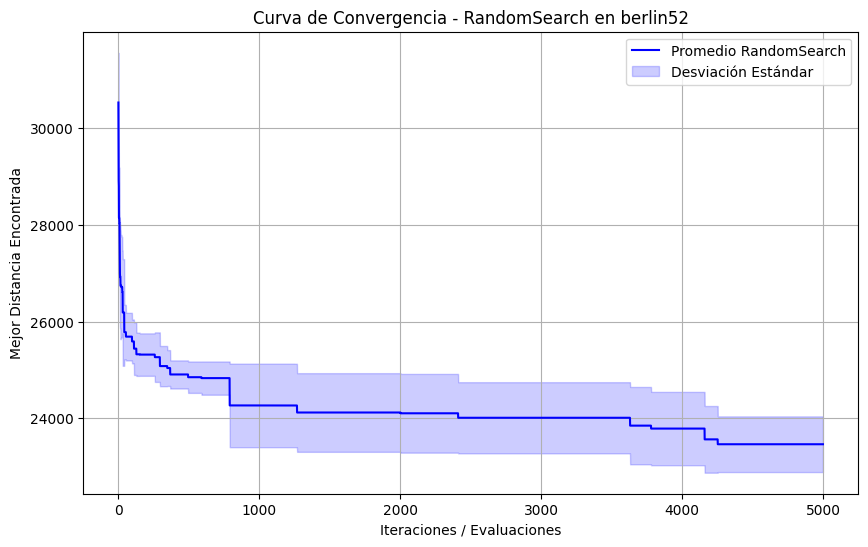


Boxplot para berlin52:


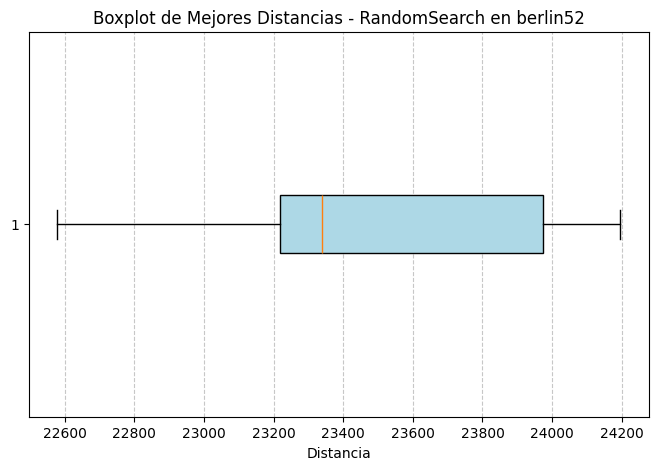



--- Iniciando experimento: RandomSearch en eil51 (5 corridas) ---
Resultados guardados exitosamente en: resultados_RandomSearch_eil51.csv

Resultados para RandomSearch en eil51:
Distancia Promedio: 1330.02 ± 13.71 (Desviación Estándar)
Mejor Distancia Global: 1314.43
Peor Distancia Global: 1341.96
Tiempo Promedio: 0.1949 s
GAP Promedio: 212.21%


Primeras filas para eil51:
   Seed  Mejor Distancia  Tiempo (s)     GAP (%)
0    42      1341.958145    0.187576  215.013649
1    43      1341.273629    0.207809  214.852965
2    44      1314.429628    0.214863  208.551556
3    45      1315.947500    0.169250  208.907864
4    46      1336.511891    0.195184  213.735186

Gráficas para eil51:

Curva de convergencia para eil51:


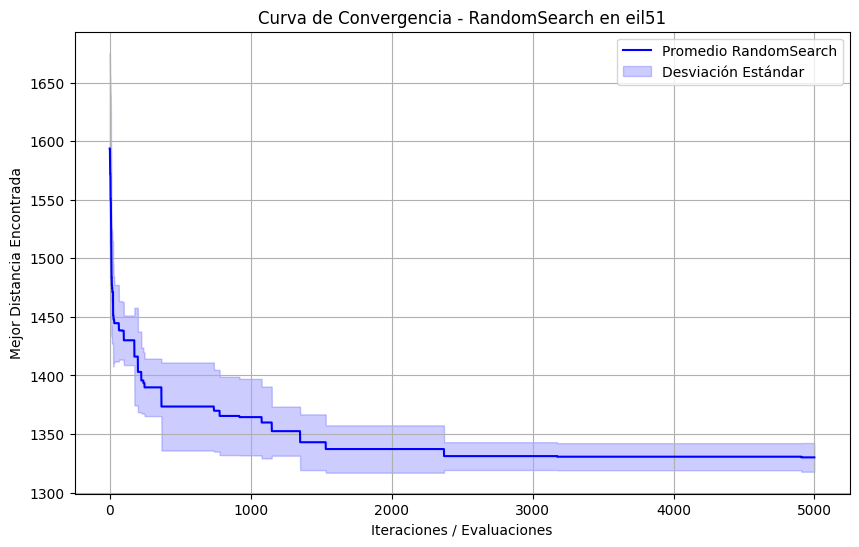


Boxplot para eil51:


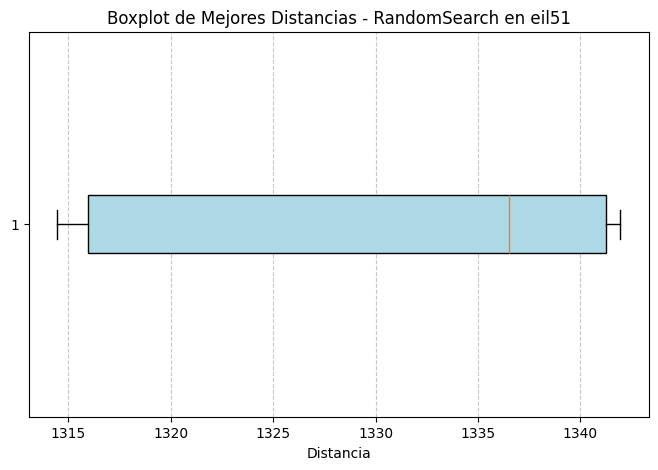



--- Iniciando experimento: RandomSearch en att48 (5 corridas) ---
Resultados guardados exitosamente en: resultados_RandomSearch_att48.csv

Resultados para RandomSearch en att48:
Distancia Promedio: 116083.76 ± 5735.82 (Desviación Estándar)
Mejor Distancia Global: 106276.78
Peor Distancia Global: 120405.25
Tiempo Promedio: 0.2391 s
GAP Promedio: 992.24%


Primeras filas para att48:
   Seed  Mejor Distancia  Tiempo (s)      GAP (%)
0    42    117638.313398    0.301818  1006.871598
1    43    106276.781801    0.182413   899.969720
2    44    120405.251715    0.285137  1032.906019
3    45    116232.117247    0.218826   993.640546
4    46    119866.330638    0.207448  1027.835253

Gráficas para att48:

Curva de convergencia para att48:


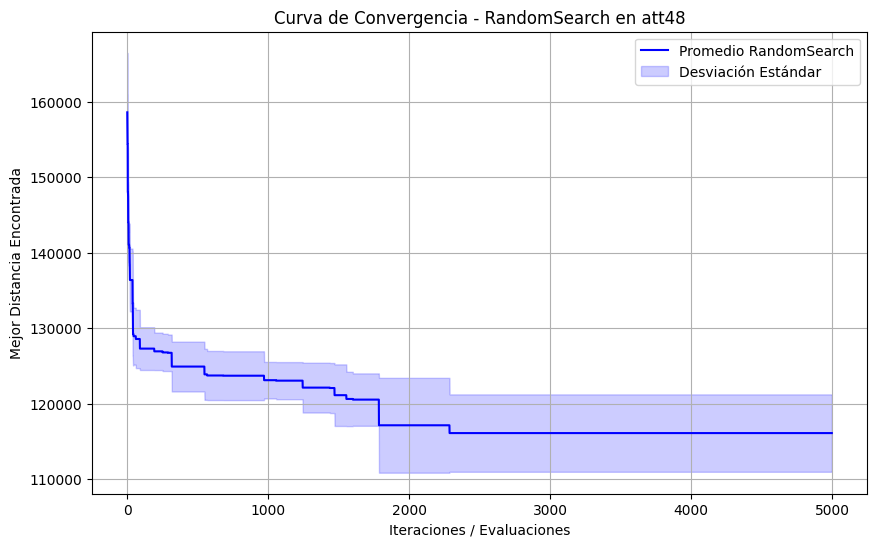


Boxplot para att48:


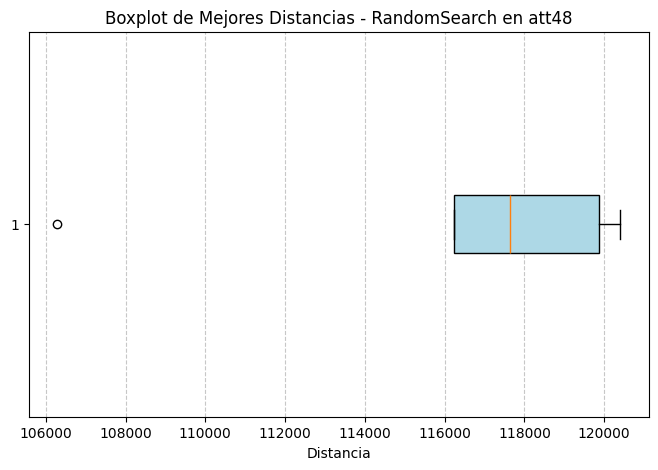



--- Iniciando experimento: RandomSearch en st70 (5 corridas) ---
Resultados guardados exitosamente en: resultados_RandomSearch_st70.csv

Resultados para RandomSearch en st70:
Distancia Promedio: 2984.50 ± 33.52 (Desviación Estándar)
Mejor Distancia Global: 2948.11
Peor Distancia Global: 3030.63
Tiempo Promedio: 0.2764 s
GAP Promedio: 342.15%


Primeras filas para st70:
   Seed  Mejor Distancia  Tiempo (s)     GAP (%)
0    42      3030.630176    0.316221  348.982248
1    43      3007.135296    0.242930  345.501525
2    44      2948.107686    0.300106  336.756694
3    45      2969.853878    0.281000  339.978352
4    46      2966.756100    0.241535  339.519422

Gráficas para st70:

Curva de convergencia para st70:


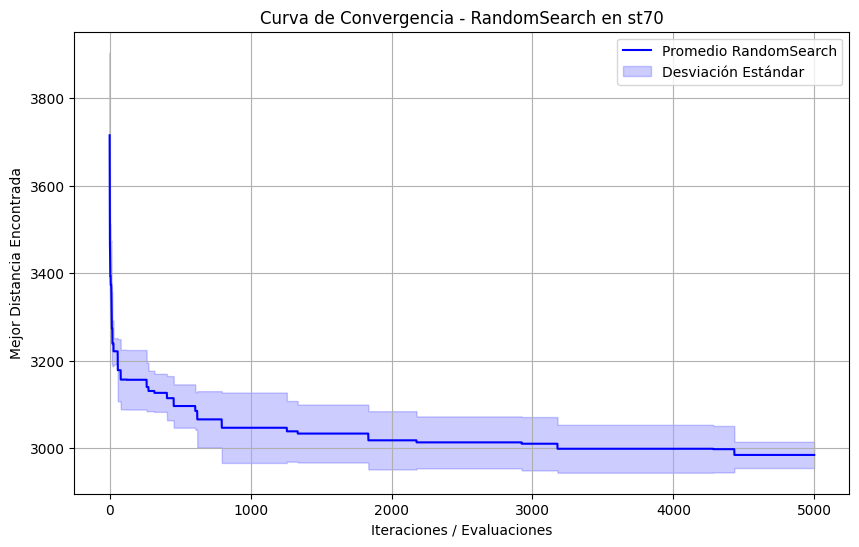


Boxplot para st70:


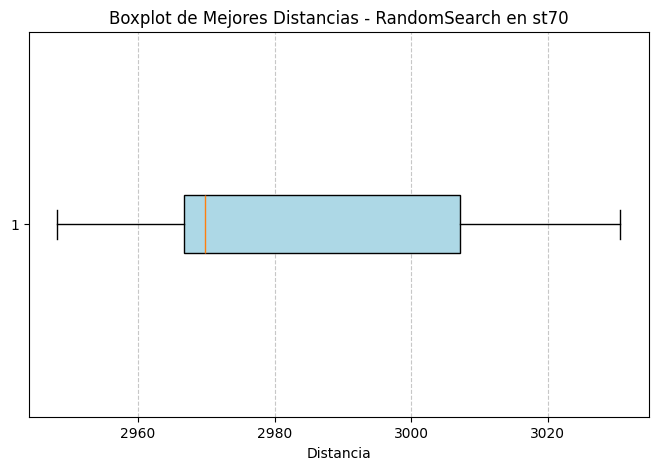




                 TABLA COMPARATIVA - BÚSQUEDA ALEATORIA (DUMMY)                  
Instancia  Óptimo Conocido  Mejor Distancia  Peor Distancia  Distancia Promedio GAP Promedio (%) Tiempo Promedio (s)
 berlin52             7542     22577.153292    24196.354800   23460.82 ± 644.17           211.07              0.1527
    eil51              426      1314.429628     1341.958145     1330.02 ± 13.71           212.21              0.1949
    att48            10628    106276.781801   120405.251715 116083.76 ± 5735.82           992.24              0.2391
     st70              675      2948.107686     3030.630176     2984.50 ± 33.52           342.15              0.2764



In [10]:
# --- Ejemplo de uso del runner ---
if __name__ == '__main__':
    # Definir 30 semillas para significancia estadística
    test_seeds = list(range(42, 47))

    summary_data_dummy = []

    for instance_name in TSP_INSTANCES.keys():
        problem = load_problem(instance_name)

        if problem:
            distance_matrix = get_distance_matrix(problem)

            # Ejecutar experimento con el algoritmo dummy (presupuesto de 5000 evaluaciones)
            df_dummy_results = run_experiment(
                algorithm_func=dummy_random_search,
                algorithm_name="RandomSearch",
                instance_name=instance_name,
                dist_matrix=distance_matrix,
                seeds=test_seeds,
                known_optimum=KNOWN_OPTIMA.get(instance_name),
                iterations=5000
            )

            # Mostrar las primeras filas del DataFrame resultante
            print(f"\nPrimeras filas para {instance_name}:")
            print(df_dummy_results[['Seed', 'Mejor Distancia', 'Tiempo (s)', 'GAP (%)']].head())

            # Graficar la curva de convergencia y boxplot
            print(f"\nGráficas para {instance_name}:")
            print(f"\nCurva de convergencia para {instance_name}:")
            plot_convergence(df_dummy_results)
            print(f"\nBoxplot para {instance_name}:")
            plot_boxplot(df_dummy_results)

            # Recopilar datos para la tabla comparativa
            mean_dist = df_dummy_results["Mejor Distancia"].mean()
            std_dist = df_dummy_results["Mejor Distancia"].std()
            best_dist = df_dummy_results["Mejor Distancia"].min()
            worst_dist = df_dummy_results["Mejor Distancia"].max()
            mean_time = df_dummy_results["Tiempo (s)"].mean()
            mean_gap = df_dummy_results["GAP (%)"].mean()

            summary_data_dummy.append({
                "Instancia": instance_name,
                "Óptimo Conocido": KNOWN_OPTIMA.get(instance_name, "N/A"),
                "Mejor Distancia": best_dist,
                "Peor Distancia": worst_dist,
                "Distancia Promedio": f"{mean_dist:.2f} ± {std_dist:.2f}",
                "GAP Promedio (%)": f"{mean_gap:.2f}" if pd.notna(mean_gap) else "N/A",
                "Tiempo Promedio (s)": f"{mean_time:.4f}"
            })

            print("\n")

    # Mostrar tabla comparativa
    if summary_data_dummy:
        print("\n=================================================================================")
        print("                 TABLA COMPARATIVA - BÚSQUEDA ALEATORIA (DUMMY)                  ")
        print("=================================================================================")
        df_summary_dummy = pd.DataFrame(summary_data_dummy)
        print(df_summary_dummy.to_string(index=False))
        print("=================================================================================\n")

---

# 3) Implementación conceptual del GA clásico (sin código)

## Componentes mínimos (TSP por permutaciones)
- Representación: permutación de ciudades
- Inicialización: población aleatoria (opcional: heurística NN para algunos individuos)
- Selección: torneo o ruleta
- Cruce: OX (Order Crossover), PMX u otro para permutaciones
- Mutación: swap / inversion / scramble
- Elitismo: conservar los mejores k

## Qué debes decidir (y reportar)
- Tamaño de población P
- Probabilidad de cruce pc
- Probabilidad de mutación pm
- Método de selección
- Elitismo k

In [11]:
# Implementar GA clásico (plantilla)
# - Define clase/funciones: init_population, selection, crossover, mutation, elitism.
# - Asegura que siempre se produzcan tours válidos (permutaciones sin repetidos).
# - Registra best-so-far por generación/tiempo.

## 1. Implementación del GA clásico

In [12]:
def init_population(dim, pop_size):
    """Inicializa una población aleatoria de permutaciones."""
    population = []
    for _ in range(pop_size):
        tour = list(range(1, dim + 1))
        np.random.shuffle(tour)
        population.append(tour)
    return population

def tournament_selection(population, distances, k=3):
    """Selección por torneo."""
    selected_indices = np.random.choice(len(population), k, replace=False)
    best_idx = selected_indices[np.argmin([distances[i] for i in selected_indices])]
    return population[best_idx]

def order_crossover(p1, p2, pc):
    """Cruce OX (Order Crossover) para permutaciones."""
    if np.random.rand() > pc:
        return p1.copy(), p2.copy()

    dim = len(p1)

    def ox(parent1, parent2):
        child = [-1] * dim
        start, end = sorted(np.random.choice(dim, 2, replace=False))
        child[start:end+1] = parent1[start:end+1]

        p2_idx = (end + 1) % dim
        c_idx = (end + 1) % dim

        # Optimización: usar un set para búsquedas O(1)
        child_set = set(child[start:end+1])

        while -1 in child:
            if parent2[p2_idx] not in child_set:
                child[c_idx] = parent2[p2_idx]
                child_set.add(parent2[p2_idx])
                c_idx = (c_idx + 1) % dim
            p2_idx = (p2_idx + 1) % dim
        return child

    return ox(p1, p2), ox(p2, p1)

def inversion_mutation(tour, pm):
    """Mutación por inversión de un segmento."""
    if np.random.rand() < pm:
        dim = len(tour)
        start, end = sorted(np.random.choice(dim, 2, replace=False))
        # Slicing [::-1] es más seguro y directo que reversed()
        tour[start:end+1] = tour[start:end+1][::-1]
    return tour

def classic_ga(dist_matrix, seed, pop_size=100, iterations=500, pc=0.8, pm=0.2, tournament_size=3, elitism_k=2):
    """Algoritmo Genético Clásico para el TSP."""
    np.random.seed(seed)
    start_time = time.time()

    dim = dist_matrix.shape[0]
    population = init_population(dim, pop_size)

    best_tour = None
    best_distance = float('inf')
    history = []

    for _ in range(iterations):
        distances = [calculate_tour_length(ind, dist_matrix) for ind in population]

        # Actualizar el mejor global
        min_idx = np.argmin(distances)
        if distances[min_idx] < best_distance:
            best_distance = distances[min_idx]
            best_tour = population[min_idx].copy()

        history.append(best_distance)

        # Elitismo
        sorted_indices = np.argsort(distances)
        new_population = [population[i].copy() for i in sorted_indices[:elitism_k]]

        # Generar nueva población
        while len(new_population) < pop_size:
            p1 = tournament_selection(population, distances, tournament_size)
            p2 = tournament_selection(population, distances, tournament_size)

            c1, c2 = order_crossover(p1, p2, pc)

            c1 = inversion_mutation(c1, pm)
            c2 = inversion_mutation(c2, pm)

            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        population = new_population

    exec_time = time.time() - start_time
    return best_tour, best_distance, history, exec_time

## 2. Ejecución

REPORTE DE DECISIONES - ALGORITMO GENÉTICO
Tamaño de población P: 100
Probabilidad de cruce pc: 0.85
Probabilidad de mutación pm: 0.15
Método de selección: Torneo (k=3)
Elitismo k: 2

--- Iniciando experimento: Classic_GA en berlin52 (5 corridas) ---
Resultados guardados exitosamente en: resultados_Classic_GA_berlin52.csv

Resultados para Classic_GA en berlin52:
Distancia Promedio: 8264.77 ± 386.07 (Desviación Estándar)
Mejor Distancia Global: 7851.82
Peor Distancia Global: 8844.19
Tiempo Promedio: 6.0373 s
GAP Promedio: 9.58%


Primeras filas para berlin52:
   Seed  Mejor Distancia  Tiempo (s)    GAP (%)
0    42      8280.102339    9.559904   9.786560
1    43      8844.194928    6.262785  17.265910
2    44      7851.815708    4.734831   4.107872
3    45      8365.154423    4.277662  10.914272
4    46      7982.585261    5.351305   5.841756

Gráficas para berlin52:

Curva de convergencia para berlin52:


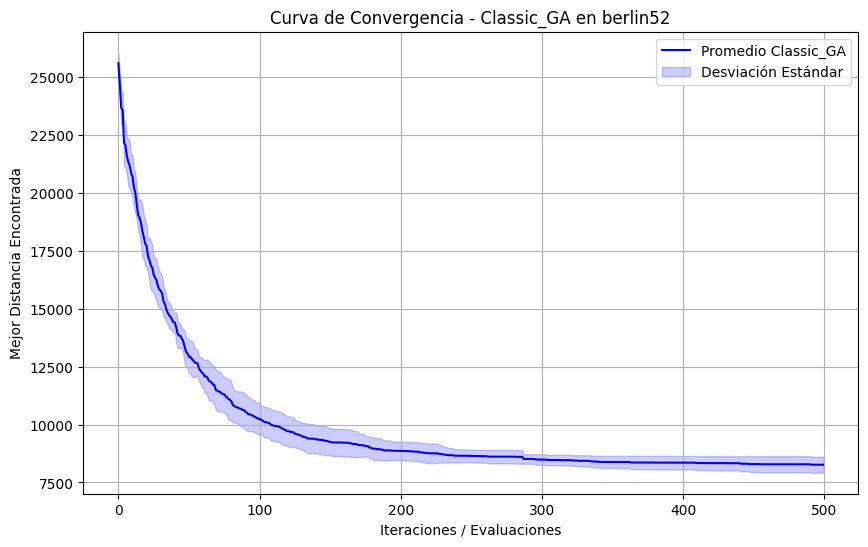


Boxplot para berlin52:


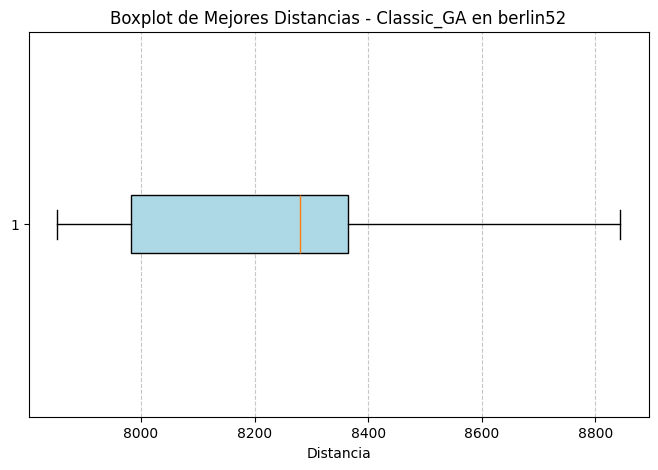



--- Iniciando experimento: Classic_GA en eil51 (5 corridas) ---
Resultados guardados exitosamente en: resultados_Classic_GA_eil51.csv

Resultados para Classic_GA en eil51:
Distancia Promedio: 459.00 ± 2.42 (Desviación Estándar)
Mejor Distancia Global: 456.89
Peor Distancia Global: 462.09
Tiempo Promedio: 4.5224 s
GAP Promedio: 7.75%


Primeras filas para eil51:
   Seed  Mejor Distancia  Tiempo (s)   GAP (%)
0    42       456.886785    4.203814  7.250419
1    43       461.130066    4.351907  8.246494
2    44       457.472743    5.231951  7.387968
3    45       462.091330    4.215614  8.472143
4    46       457.418239    4.608469  7.375174

Gráficas para eil51:

Curva de convergencia para eil51:


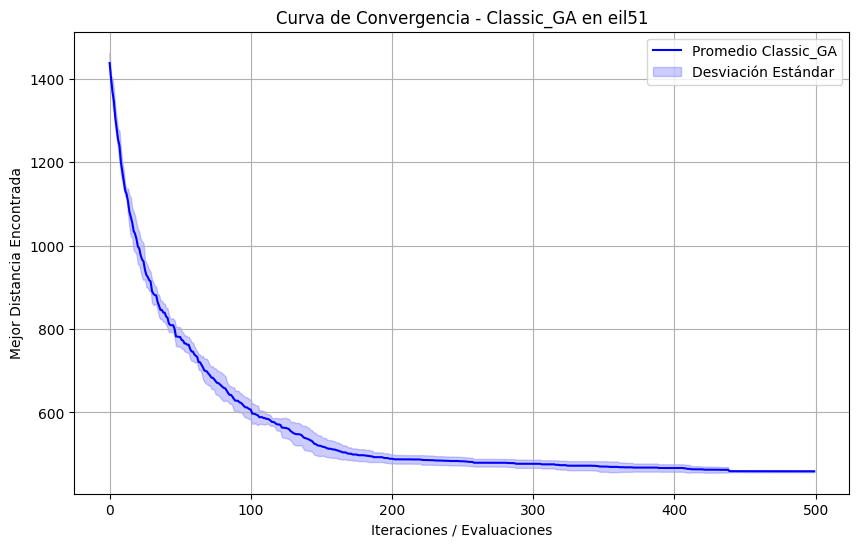


Boxplot para eil51:


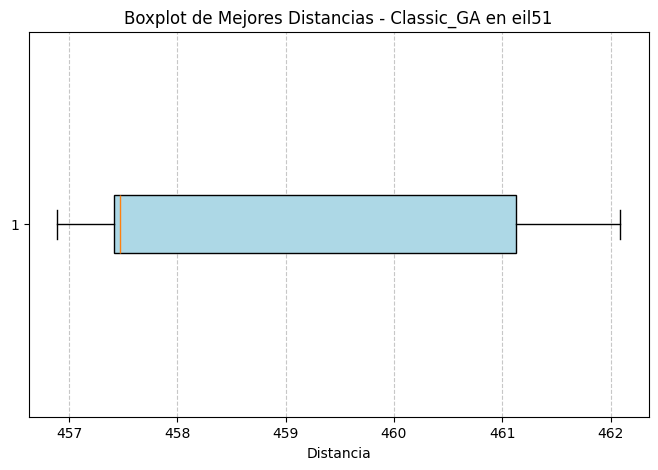



--- Iniciando experimento: Classic_GA en att48 (5 corridas) ---
Resultados guardados exitosamente en: resultados_Classic_GA_att48.csv

Resultados para Classic_GA en att48:
Distancia Promedio: 34957.42 ± 779.50 (Desviación Estándar)
Mejor Distancia Global: 34107.07
Peor Distancia Global: 35996.21
Tiempo Promedio: 4.4121 s
GAP Promedio: 228.92%


Primeras filas para att48:
   Seed  Mejor Distancia  Tiempo (s)     GAP (%)
0    42     35338.428043    4.561301  232.503087
1    43     35073.292916    4.078920  230.008402
2    44     35996.213788    5.115016  238.692264
3    45     34272.092404    4.153227  222.469819
4    46     34107.065029    4.152235  220.917059

Gráficas para att48:

Curva de convergencia para att48:


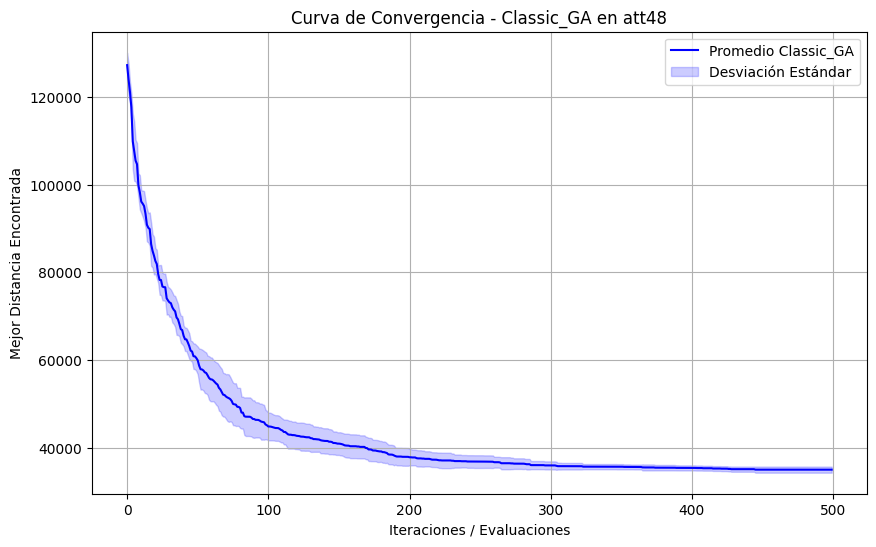


Boxplot para att48:


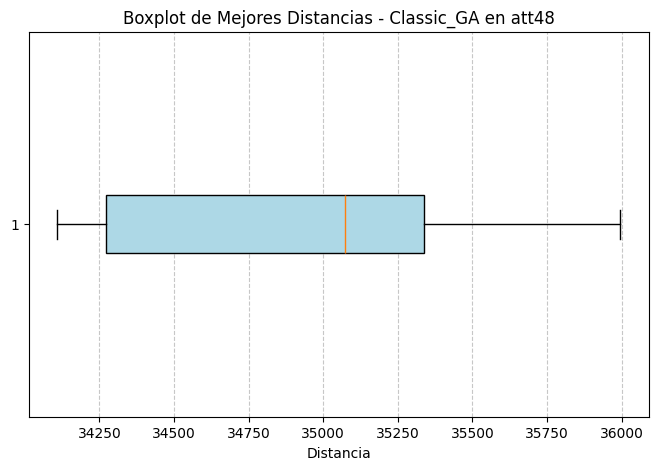



--- Iniciando experimento: Classic_GA en st70 (5 corridas) ---
Resultados guardados exitosamente en: resultados_Classic_GA_st70.csv

Resultados para Classic_GA en st70:
Distancia Promedio: 747.32 ± 16.08 (Desviación Estándar)
Mejor Distancia Global: 723.64
Peor Distancia Global: 763.51
Tiempo Promedio: 5.4473 s
GAP Promedio: 10.71%


Primeras filas para st70:
   Seed  Mejor Distancia  Tiempo (s)    GAP (%)
0    42       741.288517    6.055611   9.820521
1    43       760.564822    4.933979  12.676270
2    44       763.507587    5.995231  13.112235
3    45       747.622730    4.957957  10.758923
4    46       723.636270    5.293691   7.205373

Gráficas para st70:

Curva de convergencia para st70:


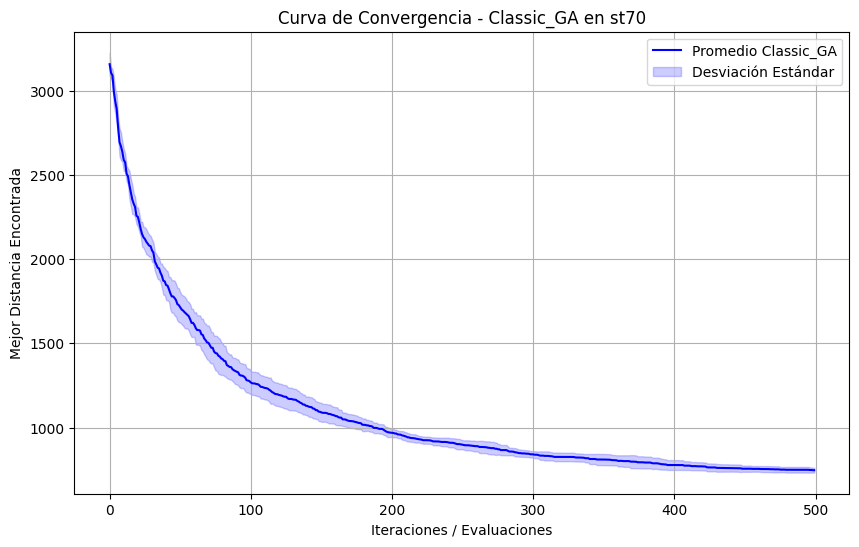


Boxplot para st70:


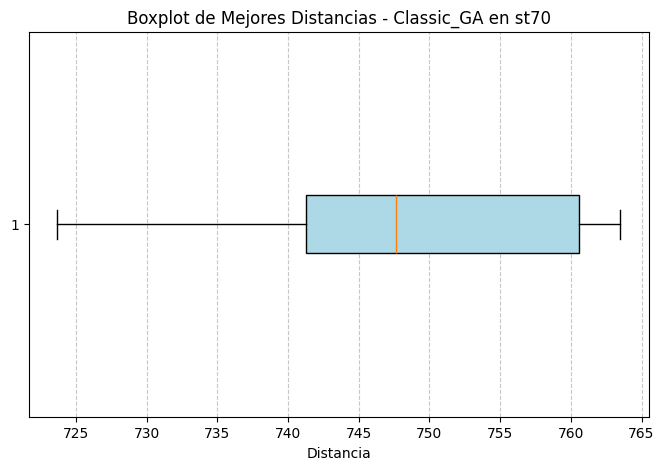




                 TABLA COMPARATIVA - ALGORITMO GENÉTICO CLÁSICO                  
Instancia  Óptimo Conocido  Mejor Distancia  Peor Distancia Distancia Promedio GAP Promedio (%) Tiempo Promedio (s)
 berlin52             7542      7851.815708     8844.194928   8264.77 ± 386.07             9.58              6.0373
    eil51              426       456.886785      462.091330      459.00 ± 2.42             7.75              4.5224
    att48            10628     34107.065029    35996.213788  34957.42 ± 779.50           228.92              4.4121
     st70              675       723.636270      763.507587     747.32 ± 16.08            10.71              5.4473



In [13]:
if __name__ == '__main__':
    test_seeds = list(range(42, 47)) # 30 semillas para el taller real

    # Definición de parámetros
    pop_size = 100
    iterations = 500
    pc = 0.85
    pm = 0.15
    tournament_size = 3
    elitism_k = 2

    # Reporte de decisiones
    print("=========================================")
    print("REPORTE DE DECISIONES - ALGORITMO GENÉTICO")
    print(f"Tamaño de población P: {pop_size}")
    print(f"Probabilidad de cruce pc: {pc}")
    print(f"Probabilidad de mutación pm: {pm}")
    print(f"Método de selección: Torneo (k={tournament_size})")
    print(f"Elitismo k: {elitism_k}")
    print("=========================================\n")

    summary_data = []

    for instance_name in TSP_INSTANCES.keys():
        problem = load_problem(instance_name)

        if problem:
            distance_matrix = get_distance_matrix(problem)

            # Ejecutar experimento con el GA Clásico
            df_ga_results = run_experiment(
                algorithm_func=classic_ga,
                algorithm_name="Classic_GA",
                instance_name=instance_name,
                dist_matrix=distance_matrix,
                seeds=test_seeds,
                known_optimum=KNOWN_OPTIMA.get(instance_name),
                pop_size=pop_size,
                iterations=iterations,
                pc=pc,
                pm=pm,
                tournament_size=tournament_size,
                elitism_k=elitism_k
            )

            # Mostrar las primeras filas del DataFrame resultante
            print(f"\nPrimeras filas para {instance_name}:")
            print(df_ga_results[['Seed', 'Mejor Distancia', 'Tiempo (s)', 'GAP (%)']].head())

            # Graficar la curva de convergencia y boxplot
            print(f"\nGráficas para {instance_name}:")
            print(f"\nCurva de convergencia para {instance_name}:")
            plot_convergence(df_ga_results)
            print(f"\nBoxplot para {instance_name}:")
            plot_boxplot(df_ga_results)

            # Recopilar datos para la tabla comparativa
            mean_dist = df_ga_results["Mejor Distancia"].mean()
            std_dist = df_ga_results["Mejor Distancia"].std()
            best_dist = df_ga_results["Mejor Distancia"].min()
            worst_dist = df_ga_results["Mejor Distancia"].max()
            mean_time = df_ga_results["Tiempo (s)"].mean()
            mean_gap = df_ga_results["GAP (%)"].mean()

            summary_data.append({
                "Instancia": instance_name,
                "Óptimo Conocido": KNOWN_OPTIMA.get(instance_name, "N/A"),
                "Mejor Distancia": best_dist,
                "Peor Distancia": worst_dist,
                "Distancia Promedio": f"{mean_dist:.2f} ± {std_dist:.2f}",
                "GAP Promedio (%)": f"{mean_gap:.2f}" if pd.notna(mean_gap) else "N/A",
                "Tiempo Promedio (s)": f"{mean_time:.4f}"
            })

            print("\n")

    # Mostrar tabla comparativa
    if summary_data:
        print("\n=================================================================================")
        print("                 TABLA COMPARATIVA - ALGORITMO GENÉTICO CLÁSICO                  ")
        print("=================================================================================")
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        print("=================================================================================\n")

### Checklist de verificación GA
- [ ] El tour siempre contiene todas las ciudades exactamente una vez.
- [ ] La evaluación del tour es consistente.
- [ ] Se guarda la historia de convergencia.
- [ ] Se puede fijar seed para reproducibilidad.

---

# 4) Implementación conceptual del ACO (sin código)

## Componentes mínimos
- Matriz de feromonas τ(i,j)
- Heurística η(i,j)=1/d(i,j)
- Regla probabilística:
\[
P_{ij} \propto (\tau_{ij})^\alpha (\eta_{ij})^\beta
\]
- Evaporación: τ ← (1−ρ)τ
- Depósito: sumar Q/L en aristas del tour

## Hiperparámetros
- Número de hormigas m
- α (peso feromona)
- β (peso heurística)
- ρ (evaporación)
- Q (intensidad de depósito)
- (opcional) elitist ants / best-ant deposit

## Qué debes decidir (y reportar)
- Cómo eliges el nodo inicial
- Cómo evitas ciclos (conjunto de no visitados)
- Qué esquema de depósito usas

In [14]:
# Implementar ACO (plantilla)
# - Define: construir_solucion(), actualizar_feromonas(), elegir_siguiente_ciudad().
# - Registra best-so-far por iteración/tiempo.
# - Controla la aleatoriedad con seed.

### Checklist de verificación ACO
- [ ] Cada hormiga produce un tour válido.
- [ ] La probabilidad está normalizada (o equivalente por muestreo).
- [ ] Evaporación y depósito no explotan numéricamente.
- [ ] Se guarda la historia de convergencia.

## 1. Implementación de Ant Colony Optimization (ACO)

In [15]:
def elegir_siguiente_ciudad(current_city, unvisited, pheromone, heuristic, alpha, beta):
    """Calcula las probabilidades y elige la siguiente ciudad."""
    unvisited_list = list(unvisited)
    probs = np.zeros(len(unvisited_list))

    for i, next_city in enumerate(unvisited_list):
        tau = pheromone[current_city, next_city] ** alpha
        eta = heuristic[current_city, next_city] ** beta
        probs[i] = tau * eta

    probs_sum = np.sum(probs)
    if probs_sum > 0:
        probs /= probs_sum
    else:
        # Fallback si las probabilidades son 0 (evitar división por cero)
        probs = np.ones(len(unvisited_list)) / len(unvisited_list)

    return np.random.choice(unvisited_list, p=probs)

def construir_solucion(dist_matrix, pheromone, heuristic, alpha, beta):
    """Construye un tour completo para una hormiga."""
    dim = dist_matrix.shape[0]
    # Nodo inicial aleatorio
    current_city = np.random.randint(dim)
    unvisited = set(range(dim))
    unvisited.remove(current_city)

    tour = [current_city + 1] # +1 para mantener consistencia 1-based
    tour_dist = 0.0

    while unvisited:
        next_city = elegir_siguiente_ciudad(current_city, unvisited, pheromone, heuristic, alpha, beta)
        tour_dist += dist_matrix[current_city, next_city]
        tour.append(next_city + 1)
        unvisited.remove(next_city)
        current_city = next_city

    # Retorno al inicio
    tour_dist += dist_matrix[current_city, tour[0] - 1]
    return tour, tour_dist

def actualizar_feromonas(pheromone, tours, distances, rho, Q, dim):
    """Aplica evaporación y depósito de feromonas."""
    # Evaporación
    pheromone *= (1.0 - rho)

    # Depósito
    for tour, dist in zip(tours, distances):
        deposit = Q / dist
        for i in range(dim):
            u = tour[i] - 1
            v = tour[(i + 1) % dim] - 1
            pheromone[u, v] += deposit
            pheromone[v, u] += deposit # Asumiendo TSP simétrico

def aco_algorithm(dist_matrix, seed, num_ants=30, iterations=100, alpha=1.0, beta=2.0, rho=0.1, Q=100.0):
    """Algoritmo Ant Colony Optimization para el TSP."""
    np.random.seed(seed)
    start_time = time.time()
    dim = dist_matrix.shape[0]

    # Matriz heurística (evitando división por cero)
    with np.errstate(divide='ignore'):
        heuristic = 1.0 / dist_matrix
    heuristic[np.isinf(heuristic)] = 0

    # Inicialización de feromonas
    pheromone = np.ones((dim, dim)) * 0.1

    best_tour = None
    best_distance = float('inf')
    history = []

    for _ in range(iterations):
        tours = []
        distances = []

        for _ in range(num_ants):
            tour, tour_dist = construir_solucion(dist_matrix, pheromone, heuristic, alpha, beta)
            tours.append(tour)
            distances.append(tour_dist)

            if tour_dist < best_distance:
                best_distance = tour_dist
                best_tour = tour.copy()

        history.append(best_distance)
        actualizar_feromonas(pheromone, tours, distances, rho, Q, dim)

    exec_time = time.time() - start_time
    return best_tour, best_distance, history, exec_time

## 2. Ejecución

REPORTE DE DECISIONES - ACO
Número de hormigas m: 30
Iteraciones: 100
Peso feromona (alpha): 1.0
Peso heurística (beta): 2.0
Tasa de evaporación (rho): 0.1
Intensidad de depósito (Q): 100.0
Nodo inicial: Aleatorio por hormiga
Evitar ciclos: Uso de conjunto (set) de nodos no visitados
Esquema de depósito: Todas las hormigas depositan Q/L

--- Iniciando experimento: ACO en berlin52 (5 corridas) ---
Resultados guardados exitosamente en: resultados_ACO_berlin52.csv

Resultados para ACO en berlin52:
Distancia Promedio: 7887.40 ± 105.72 (Desviación Estándar)
Mejor Distancia Global: 7737.78
Peor Distancia Global: 8019.28
Tiempo Promedio: 9.6030 s
GAP Promedio: 4.58%


Primeras filas para berlin52:
   Seed  Mejor Distancia  Tiempo (s)   GAP (%)
0    42      7938.156491    9.796156  5.252672
1    43      7737.784888    9.842433  2.595928
2    44      7840.793067    9.796055  3.961722
3    45      7900.968295    9.805106  4.759590
4    46      8019.275093    8.775059  6.328230

Gráficas para ber

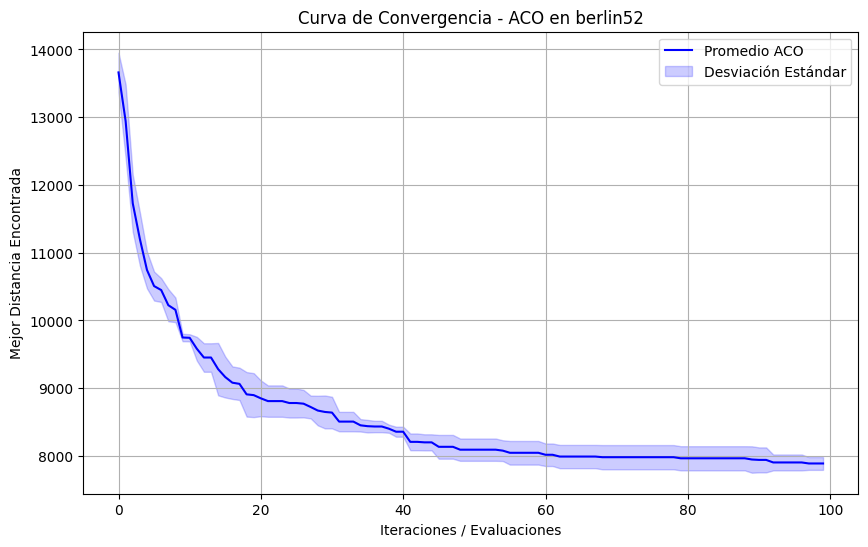


Boxplot para berlin52:


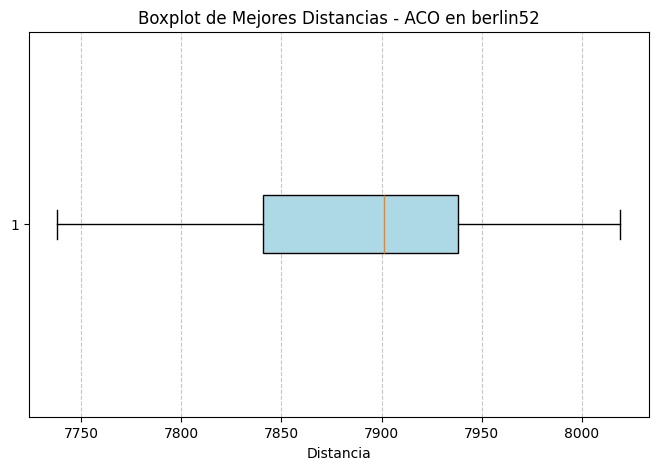



--- Iniciando experimento: ACO en eil51 (5 corridas) ---
Resultados guardados exitosamente en: resultados_ACO_eil51.csv

Resultados para ACO en eil51:
Distancia Promedio: 470.29 ± 5.32 (Desviación Estándar)
Mejor Distancia Global: 462.95
Peor Distancia Global: 476.89
Tiempo Promedio: 9.6816 s
GAP Promedio: 10.40%


Primeras filas para eil51:
   Seed  Mejor Distancia  Tiempo (s)    GAP (%)
0    42       473.013038   10.479792  11.035924
1    43       462.946677    9.660022   8.672929
2    44       467.532813    9.736922   9.749487
3    45       476.891609    8.714055  11.946387
4    46       471.073708    9.817180  10.580683

Gráficas para eil51:

Curva de convergencia para eil51:


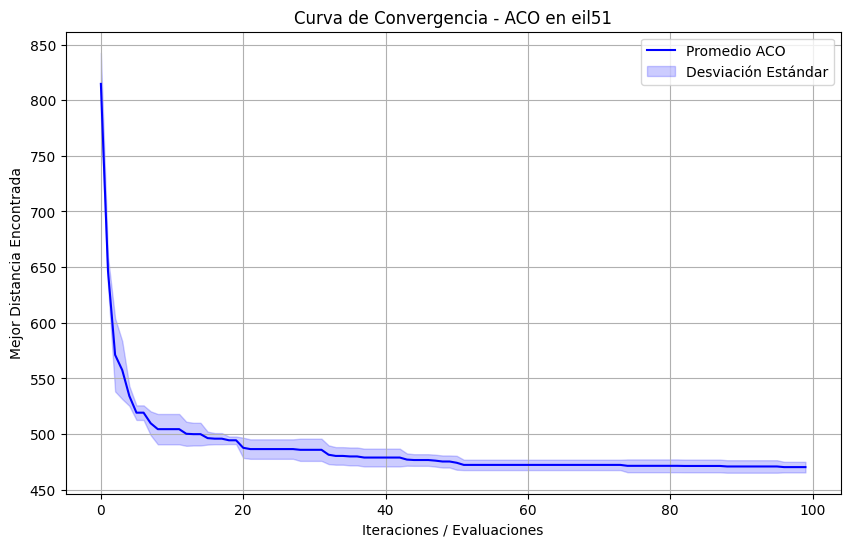


Boxplot para eil51:


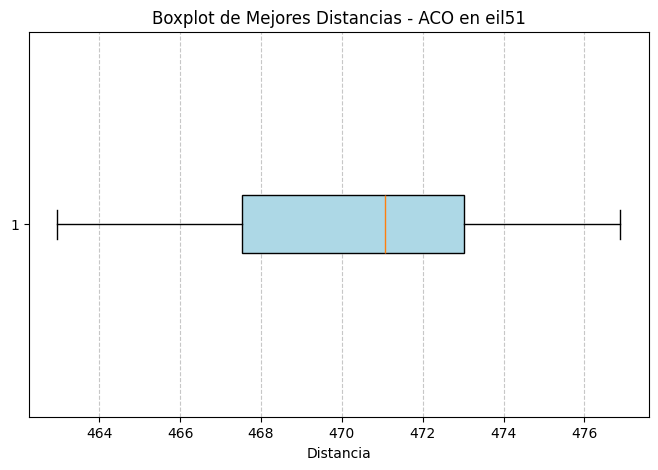



--- Iniciando experimento: ACO en att48 (5 corridas) ---
Resultados guardados exitosamente en: resultados_ACO_att48.csv

Resultados para ACO en att48:
Distancia Promedio: 35531.95 ± 1322.09 (Desviación Estándar)
Mejor Distancia Global: 33625.62
Peor Distancia Global: 36709.82
Tiempo Promedio: 8.7164 s
GAP Promedio: 234.32%


Primeras filas para att48:
   Seed  Mejor Distancia  Tiempo (s)     GAP (%)
0    42     36709.815012    8.948715  245.406615
1    43     36164.305999    8.914475  240.273861
2    44     36464.810598    7.797037  243.101342
3    45     34695.205996    8.961964  226.450941
4    46     33625.617070    8.959846  216.387063

Gráficas para att48:

Curva de convergencia para att48:


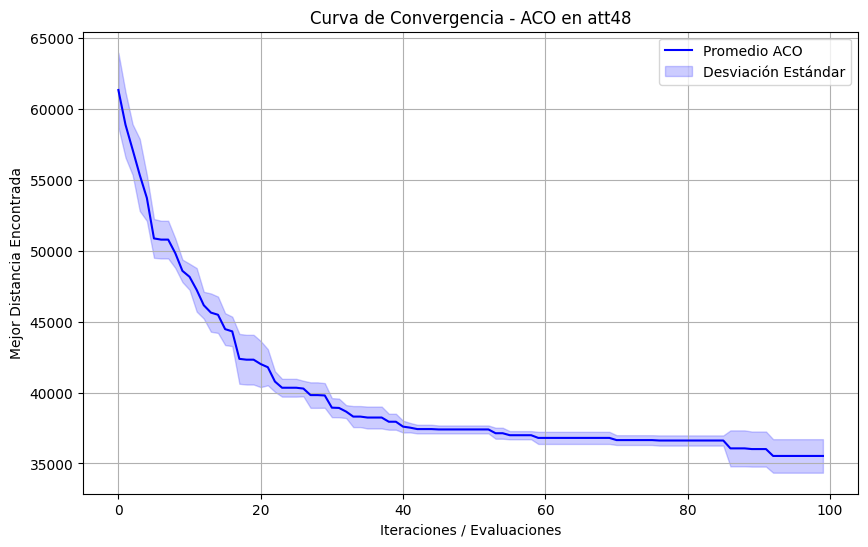


Boxplot para att48:


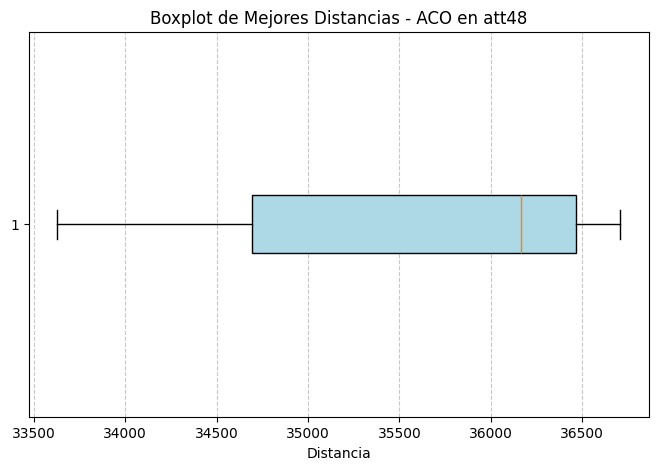



--- Iniciando experimento: ACO en st70 (5 corridas) ---
Resultados guardados exitosamente en: resultados_ACO_st70.csv

Resultados para ACO en st70:
Distancia Promedio: 762.00 ± 7.07 (Desviación Estándar)
Mejor Distancia Global: 752.11
Peor Distancia Global: 771.25
Tiempo Promedio: 14.8421 s
GAP Promedio: 12.89%


Primeras filas para st70:
   Seed  Mejor Distancia  Tiempo (s)    GAP (%)
0    42       760.846804   14.809309  12.718045
1    43       765.504435   14.726758  13.408064
2    44       771.250051   14.683378  14.259267
3    45       760.295504   14.467607  12.636371
4    46       752.114178   15.523496  11.424323

Gráficas para st70:

Curva de convergencia para st70:


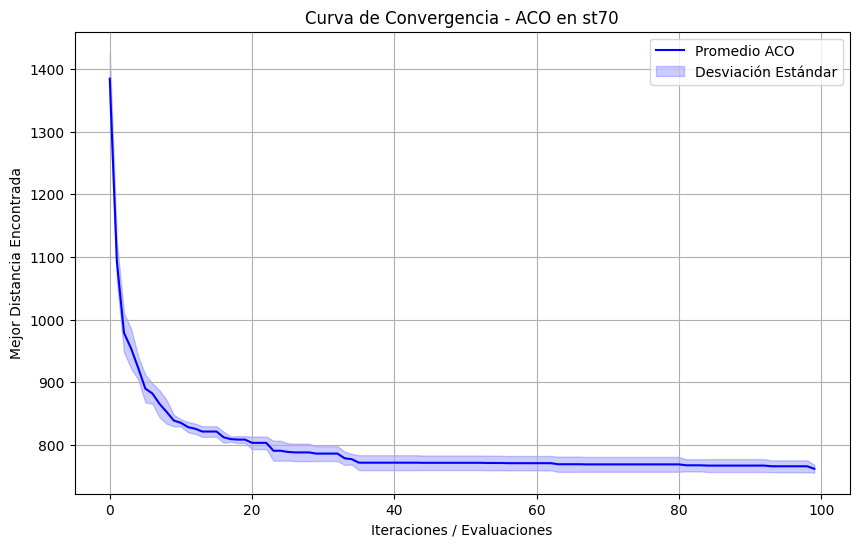


Boxplot para st70:


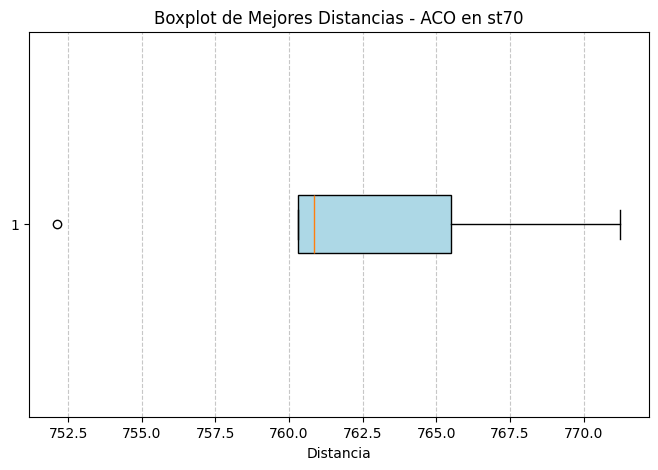




                 TABLA COMPARATIVA - ANT COLONY OPTIMIZATION (ACO)               
Instancia  Óptimo Conocido  Mejor Distancia  Peor Distancia Distancia Promedio GAP Promedio (%) Tiempo Promedio (s)
 berlin52             7542      7737.784888     8019.275093   7887.40 ± 105.72             4.58              9.6030
    eil51              426       462.946677      476.891609      470.29 ± 5.32            10.40              9.6816
    att48            10628     33625.617070    36709.815012 35531.95 ± 1322.09           234.32              8.7164
     st70              675       752.114178      771.250051      762.00 ± 7.07            12.89             14.8421



In [16]:
# --- Ejecución ACO ---
if __name__ == '__main__':
    test_seeds = list(range(42, 47)) # 30 semillas

    # Definición de hiperparámetros ACO
    num_ants = 30
    aco_iterations = 100
    alpha = 1.0
    beta = 2.0
    rho = 0.1
    Q = 100.0

    # Reporte de decisiones
    print("=========================================")
    print("REPORTE DE DECISIONES - ACO")
    print(f"Número de hormigas m: {num_ants}")
    print(f"Iteraciones: {aco_iterations}")
    print(f"Peso feromona (alpha): {alpha}")
    print(f"Peso heurística (beta): {beta}")
    print(f"Tasa de evaporación (rho): {rho}")
    print(f"Intensidad de depósito (Q): {Q}")
    print("Nodo inicial: Aleatorio por hormiga")
    print("Evitar ciclos: Uso de conjunto (set) de nodos no visitados")
    print("Esquema de depósito: Todas las hormigas depositan Q/L")
    print("=========================================\n")

    summary_data_aco = []

    for instance_name in TSP_INSTANCES.keys():
        problem = load_problem(instance_name)

        if problem:
            distance_matrix = get_distance_matrix(problem)

            # Ejecutar experimento con ACO
            df_aco_results = run_experiment(
                algorithm_func=aco_algorithm,
                algorithm_name="ACO",
                instance_name=instance_name,
                dist_matrix=distance_matrix,
                seeds=test_seeds,
                known_optimum=KNOWN_OPTIMA.get(instance_name),
                num_ants=num_ants,
                iterations=aco_iterations,
                alpha=alpha,
                beta=beta,
                rho=rho,
                Q=Q
            )

            # Mostrar las primeras filas del DataFrame resultante
            print(f"\nPrimeras filas para {instance_name}:")
            print(df_aco_results[['Seed', 'Mejor Distancia', 'Tiempo (s)', 'GAP (%)']].head())

            # Graficar la curva de convergencia y boxplot
            print(f"\nGráficas para {instance_name}:")
            print(f"\nCurva de convergencia para {instance_name}:")
            plot_convergence(df_aco_results)
            print(f"\nBoxplot para {instance_name}:")
            plot_boxplot(df_aco_results)

            # Recopilar datos para la tabla comparativa
            mean_dist = df_aco_results["Mejor Distancia"].mean()
            std_dist = df_aco_results["Mejor Distancia"].std()
            best_dist = df_aco_results["Mejor Distancia"].min()
            worst_dist = df_aco_results["Mejor Distancia"].max()
            mean_time = df_aco_results["Tiempo (s)"].mean()
            mean_gap = df_aco_results["GAP (%)"].mean()

            summary_data_aco.append({
                "Instancia": instance_name,
                "Óptimo Conocido": KNOWN_OPTIMA.get(instance_name, "N/A"),
                "Mejor Distancia": best_dist,
                "Peor Distancia": worst_dist,
                "Distancia Promedio": f"{mean_dist:.2f} ± {std_dist:.2f}",
                "GAP Promedio (%)": f"{mean_gap:.2f}" if pd.notna(mean_gap) else "N/A",
                "Tiempo Promedio (s)": f"{mean_time:.4f}"
            })

            print("\n")

    # Mostrar tabla comparativa
    if summary_data_aco:
        print("\n=================================================================================")
        print("                 TABLA COMPARATIVA - ANT COLONY OPTIMIZATION (ACO)               ")
        print("=================================================================================")
        df_summary_aco = pd.DataFrame(summary_data_aco)
        print(df_summary_aco.to_string(index=False))
        print("=================================================================================\n")

---

# 5) PLUS: Algoritmo Genético de Chu–Beasley (CBGA) (sin código)

Este “GA” es más **controlado**: regula diversidad y reemplazo.

## Ideas clave (a implementar)
1. **Población sin duplicados**: no permitas individuos iguales.
2. **Reemplazo selectivo**: un hijo entra SOLO si mejora a alguien (y si respeta diversidad).
3. **Control explícito de diversidad**: define una medida de diferencia entre tours (por ejemplo, distancia de Hamming o diferencia de aristas).
4. **Intensificación local (opcional recomendado)**: aplicar 2-opt a los mejores o a nuevos individuos.

## Lo que debes definir
- Métrica de diversidad entre tours
- Umbral mínimo de diversidad
- Política de reemplazo (a quién saca el nuevo individuo)
- Cuándo aplicar búsqueda local (si lo haces)

In [17]:
# Implementar CBGA (plantilla)
# - Define control de duplicados (hash de tour o conjunto de aristas).
# - Define medida de diversidad y umbral.
# - Define política de reemplazo (peor, más parecido, etc.).
# - Registra best-so-far.

## 1. Implementación de Chu-Beasley Genetic Algorithm (CBGA)

In [18]:
def calculate_diversity(tour1, tour2):
    """Calcula la diversidad usando la distancia de Hamming (posiciones diferentes)."""
    return sum(1 for a, b in zip(tour1, tour2) if a != b)

def fast_2opt(tour, dist_matrix, max_improvements=20):
    """Aplica una búsqueda local 2-opt rápida para intensificación."""
    best_tour = tour.copy()
    dim = len(tour)
    improved = True
    improvements = 0

    while improved and improvements < max_improvements:
        improved = False
        for i in range(1, dim - 1):
            for j in range(i + 1, dim):
                n1, n2 = best_tour[i-1] - 1, best_tour[i] - 1
                n3, n4 = best_tour[j-1] - 1, best_tour[j % dim] - 1

                old_dist = dist_matrix[n1, n2] + dist_matrix[n3, n4]
                new_dist = dist_matrix[n1, n3] + dist_matrix[n2, n4]

                if new_dist < old_dist:
                    best_tour[i:j] = list(reversed(best_tour[i:j]))
                    improved = True
                    improvements += 1
                    break
            if improved:
                break

    return best_tour, calculate_tour_length(best_tour, dist_matrix)

def cbga_algorithm(dist_matrix, seed, pop_size=50, iterations=500, threshold=10):
    """Algoritmo Genético de Chu-Beasley para el TSP."""
    np.random.seed(seed)
    start_time = time.time()
    dim = dist_matrix.shape[0]

    population = []
    pop_distances = []

    # Inicialización con control de diversidad
    attempts = 0
    while len(population) < pop_size and attempts < pop_size * 10:
        tour = list(range(1, dim + 1))
        np.random.shuffle(tour)
        tour, dist = fast_2opt(tour, dist_matrix)

        is_diverse = all(calculate_diversity(tour, p) >= threshold for p in population)
        if is_diverse or not population:
            population.append(tour)
            pop_distances.append(dist)
        attempts += 1

    # Rellenar si el umbral fue muy estricto
    while len(population) < pop_size:
        tour = list(range(1, dim + 1))
        np.random.shuffle(tour)
        tour, dist = fast_2opt(tour, dist_matrix)
        population.append(tour)
        pop_distances.append(dist)

    best_distance = min(pop_distances)
    best_tour = population[np.argmin(pop_distances)].copy()
    history = []

    for _ in range(iterations):
        # Selección por torneo binario
        idx1 = np.random.choice(pop_size, 2, replace=False)
        p1_idx = idx1[np.argmin([pop_distances[i] for i in idx1])]

        idx2 = np.random.choice(pop_size, 2, replace=False)
        p2_idx = idx2[np.argmin([pop_distances[i] for i in idx2])]

        # Cruce (reutilizando order_crossover del GA clásico)
        c1, c2 = order_crossover(population[p1_idx], population[p2_idx], pc=1.0)
        child = c1 if np.random.rand() < 0.5 else c2

        # Búsqueda local
        child, child_dist = fast_2opt(child, dist_matrix)

        # Reemplazo selectivo
        worst_idx = np.argmax(pop_distances)
        if child_dist < pop_distances[worst_idx]:
            is_diverse = True
            for i, p in enumerate(population):
                if i != worst_idx and calculate_diversity(child, p) < threshold:
                    is_diverse = False
                    break

            if is_diverse:
                population[worst_idx] = child
                pop_distances[worst_idx] = child_dist
                if child_dist < best_distance:
                    best_distance = child_dist
                    best_tour = child.copy()

        history.append(best_distance)

    exec_time = time.time() - start_time
    return best_tour, best_distance, history, exec_time

## 2. Ejecución CBGA

REPORTE DE DECISIONES - CBGA
Tamaño de población P: 50
Iteraciones: 500
Umbral de diversidad (Hamming): 10
Búsqueda local: 2-opt rápido (max 20 mejoras)
Política de reemplazo: El hijo reemplaza al peor si es mejor y mantiene diversidad

--- Iniciando experimento: CBGA en berlin52 (5 corridas) ---
Resultados guardados exitosamente en: resultados_CBGA_berlin52.csv

Resultados para CBGA en berlin52:
Distancia Promedio: 7544.37 ± 0.00 (Desviación Estándar)
Mejor Distancia Global: 7544.37
Peor Distancia Global: 7544.37
Tiempo Promedio: 3.2648 s
GAP Promedio: 0.03%


Primeras filas para berlin52:
   Seed  Mejor Distancia  Tiempo (s)  GAP (%)
0    42      7544.365902    2.925058  0.03137
1    43      7544.365902    3.165012  0.03137
2    44      7544.365902    2.948205  0.03137
3    45      7544.365902    4.281873  0.03137
4    46      7544.365902    3.003870  0.03137

Gráficas para berlin52:

Curva de convergencia para berlin52:


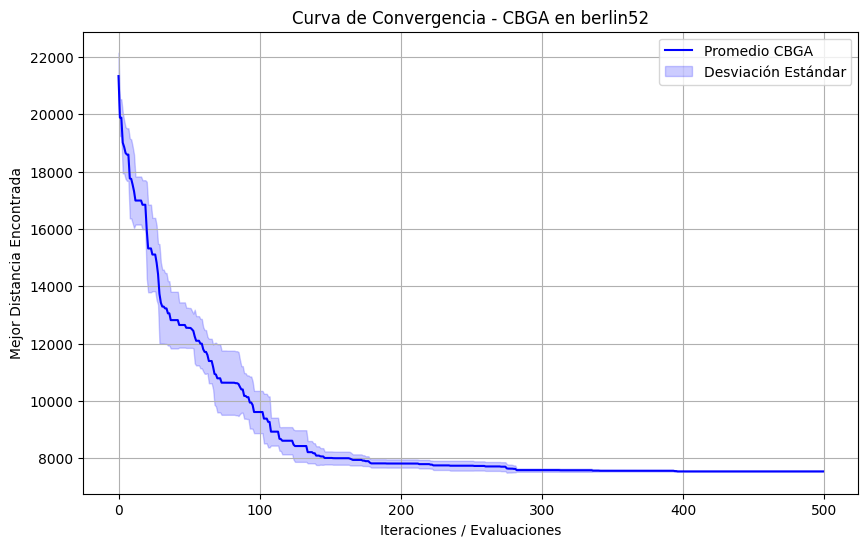


Boxplot para berlin52:


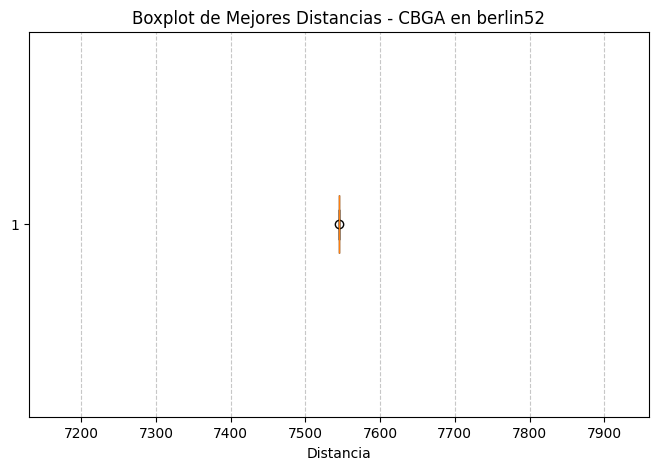



--- Iniciando experimento: CBGA en eil51 (5 corridas) ---
Resultados guardados exitosamente en: resultados_CBGA_eil51.csv

Resultados para CBGA en eil51:
Distancia Promedio: 430.75 ± 0.75 (Desviación Estándar)
Mejor Distancia Global: 429.48
Peor Distancia Global: 431.32
Tiempo Promedio: 3.0598 s
GAP Promedio: 1.12%


Primeras filas para eil51:
   Seed  Mejor Distancia  Tiempo (s)   GAP (%)
0    42       431.321382    2.861049  1.249151
1    43       430.746455    2.866724  1.114191
2    44       430.883023    3.819282  1.146249
3    45       431.321382    2.809100  1.249151
4    46       429.484081    2.942853  0.817859

Gráficas para eil51:

Curva de convergencia para eil51:


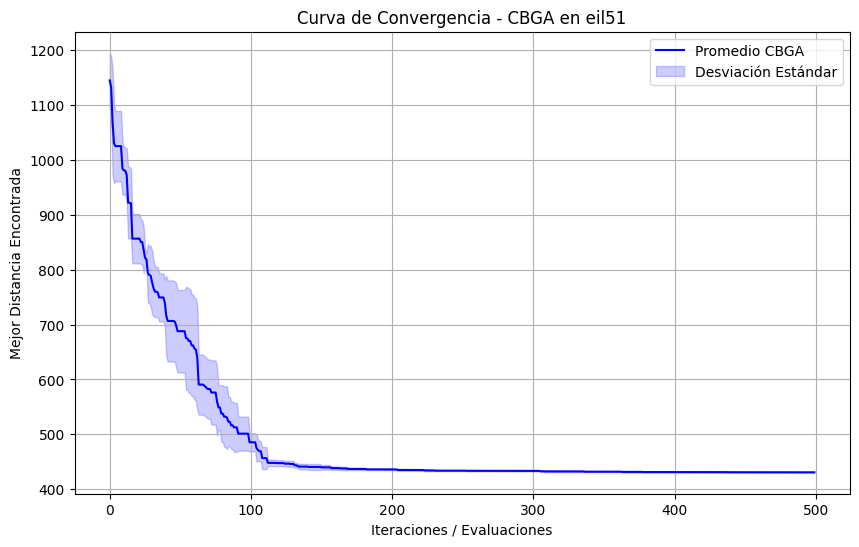


Boxplot para eil51:


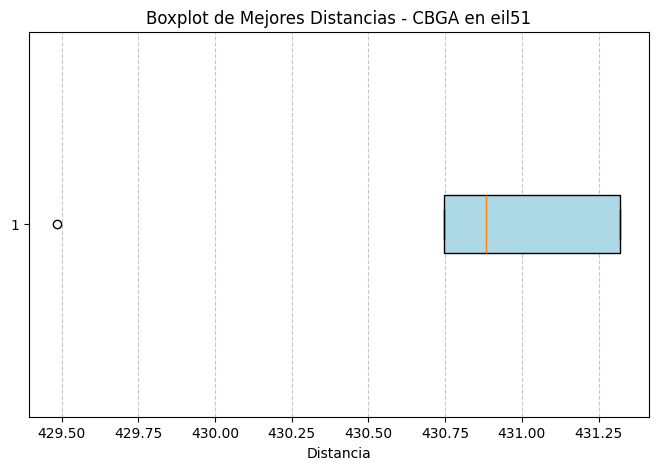



--- Iniciando experimento: CBGA en att48 (5 corridas) ---
Resultados guardados exitosamente en: resultados_CBGA_att48.csv

Resultados para CBGA en att48:
Distancia Promedio: 33578.68 ± 32.34 (Desviación Estándar)
Mejor Distancia Global: 33555.28
Peor Distancia Global: 33619.91
Tiempo Promedio: 2.6464 s
GAP Promedio: 215.95%


Primeras filas para att48:
   Seed  Mejor Distancia  Tiempo (s)     GAP (%)
0    42     33555.276457    2.554912  215.725221
1    43     33607.682298    3.541426  216.218313
2    44     33555.276457    2.408760  215.725221
3    45     33555.276457    2.309209  215.725221
4    46     33619.911359    2.417444  216.333377

Gráficas para att48:

Curva de convergencia para att48:


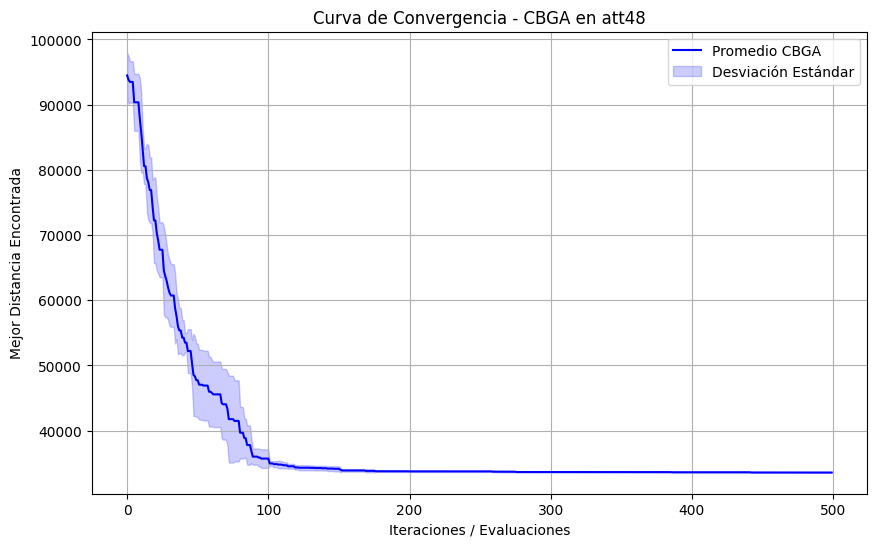


Boxplot para att48:


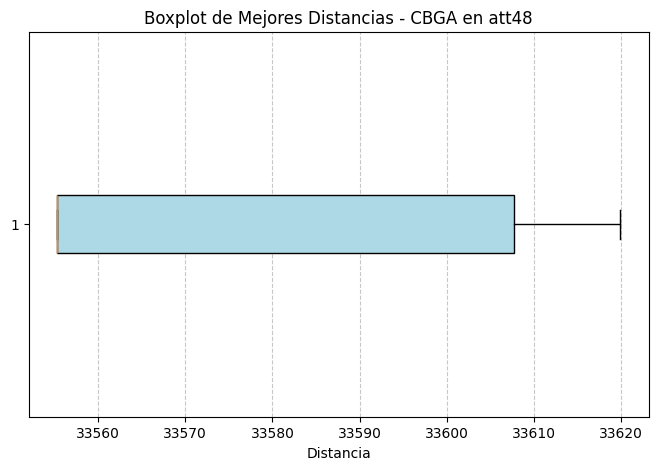



--- Iniciando experimento: CBGA en st70 (5 corridas) ---
Resultados guardados exitosamente en: resultados_CBGA_st70.csv

Resultados para CBGA en st70:
Distancia Promedio: 683.75 ± 4.31 (Desviación Estándar)
Mejor Distancia Global: 679.65
Peor Distancia Global: 688.74
Tiempo Promedio: 4.9115 s
GAP Promedio: 1.30%


Primeras filas para st70:
   Seed  Mejor Distancia  Tiempo (s)   GAP (%)
0    42       679.654800    5.235105  0.689600
1    43       688.739589    4.301164  2.035495
2    44       680.303639    5.283844  0.785724
3    45       687.970820    5.229962  1.921603
4    46       682.065706    4.507262  1.046771

Gráficas para st70:

Curva de convergencia para st70:


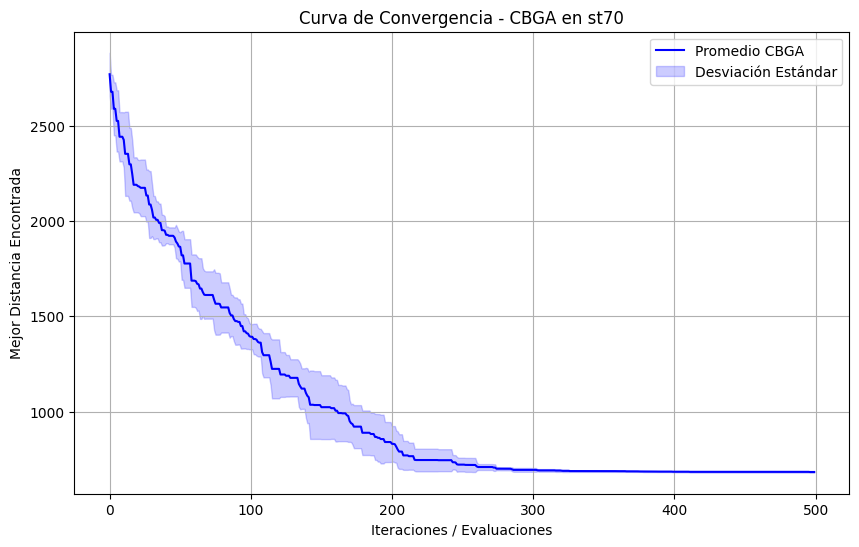


Boxplot para st70:


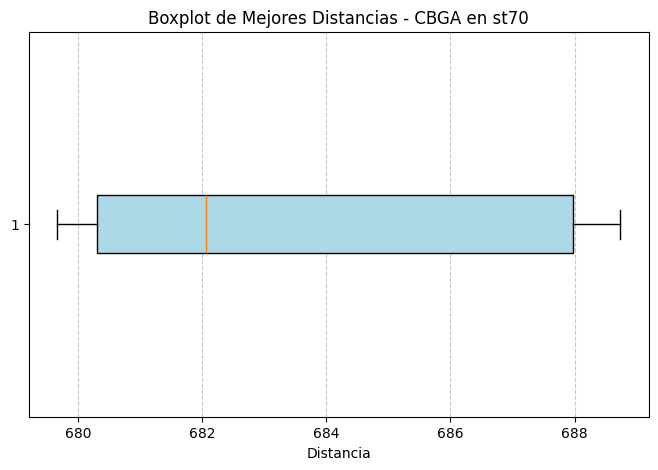




           TABLA COMPARATIVA - CHU-BEASLEY GENETIC ALGORITHM (CBGA)              
Instancia  Óptimo Conocido  Mejor Distancia  Peor Distancia Distancia Promedio GAP Promedio (%) Tiempo Promedio (s)
 berlin52             7542      7544.365902     7544.365902     7544.37 ± 0.00             0.03              3.2648
    eil51              426       429.484081      431.321382      430.75 ± 0.75             1.12              3.0598
    att48            10628     33555.276457    33619.911359   33578.68 ± 32.34           215.95              2.6464
     st70              675       679.654800      688.739589      683.75 ± 4.31             1.30              4.9115



In [19]:
if __name__ == '__main__':
    test_seeds = list(range(42, 47)) # 30 semillas

    # Definición de hiperparámetros CBGA
    pop_size_cbga = 50
    iterations_cbga = 500
    diversity_threshold = 10

    # Reporte de decisiones
    print("=========================================")
    print("REPORTE DE DECISIONES - CBGA")
    print(f"Tamaño de población P: {pop_size_cbga}")
    print(f"Iteraciones: {iterations_cbga}")
    print(f"Umbral de diversidad (Hamming): {diversity_threshold}")
    print("Búsqueda local: 2-opt rápido (max 20 mejoras)")
    print("Política de reemplazo: El hijo reemplaza al peor si es mejor y mantiene diversidad")
    print("=========================================\n")

    summary_data_cbga = []

    for instance_name in TSP_INSTANCES.keys():
        problem = load_problem(instance_name)

        if problem:
            distance_matrix = get_distance_matrix(problem)

            # Ejecutar experimento con CBGA
            df_cbga_results = run_experiment(
                algorithm_func=cbga_algorithm,
                algorithm_name="CBGA",
                instance_name=instance_name,
                dist_matrix=distance_matrix,
                seeds=test_seeds,
                known_optimum=KNOWN_OPTIMA.get(instance_name),
                pop_size=pop_size_cbga,
                iterations=iterations_cbga,
                threshold=diversity_threshold
            )

            # Mostrar las primeras filas del DataFrame resultante
            print(f"\nPrimeras filas para {instance_name}:")
            print(df_cbga_results[['Seed', 'Mejor Distancia', 'Tiempo (s)', 'GAP (%)']].head())

            # Graficar la curva de convergencia y boxplot
            print(f"\nGráficas para {instance_name}:")
            print(f"\nCurva de convergencia para {instance_name}:")
            plot_convergence(df_cbga_results)
            print(f"\nBoxplot para {instance_name}:")
            plot_boxplot(df_cbga_results)

            # Recopilar datos para la tabla comparativa
            mean_dist = df_cbga_results["Mejor Distancia"].mean()
            std_dist = df_cbga_results["Mejor Distancia"].std()
            best_dist = df_cbga_results["Mejor Distancia"].min()
            worst_dist = df_cbga_results["Mejor Distancia"].max()
            mean_time = df_cbga_results["Tiempo (s)"].mean()
            mean_gap = df_cbga_results["GAP (%)"].mean()

            summary_data_cbga.append({
                "Instancia": instance_name,
                "Óptimo Conocido": KNOWN_OPTIMA.get(instance_name, "N/A"),
                "Mejor Distancia": best_dist,
                "Peor Distancia": worst_dist,
                "Distancia Promedio": f"{mean_dist:.2f} ± {std_dist:.2f}",
                "GAP Promedio (%)": f"{mean_gap:.2f}" if pd.notna(mean_gap) else "N/A",
                "Tiempo Promedio (s)": f"{mean_time:.4f}"
            })

            print("\n")

    # Mostrar tabla comparativa
    if summary_data_cbga:
        print("\n=================================================================================")
        print("           TABLA COMPARATIVA - CHU-BEASLEY GENETIC ALGORITHM (CBGA)              ")
        print("=================================================================================")
        df_summary_cbga = pd.DataFrame(summary_data_cbga)
        print(df_summary_cbga.to_string(index=False))
        print("=================================================================================\n")

---

# 6) Afinamiento (tuning) de hiperparámetros

## Enfoque recomendado: tuning por fases

### Fase 1: Baseline
- Elige parámetros “razonables” y ejecuta 30 seeds.
- Obtén curvas y tabla comparativa.

### Fase 2: Búsqueda de parámetros (una variable a la vez)
- Cambia **solo 1** parámetro y mide el impacto.

### Fase 3: Búsqueda en rejilla (grid) o aleatoria
- Explora combinaciones (pocas, pero informativas).

## Parámetros sugeridos para explorar
### GA
- P ∈ {50, 100, 200}
- pm ∈ {0.01, 0.03, 0.05, 0.10}
- pc ∈ {0.7, 0.85, 0.95}
- elitismo k ∈ {1, 2, 5}

### ACO
- m ∈ {10, 20, 40}
- α ∈ {0.5, 1, 2}
- β ∈ {2, 5, 8}
- ρ ∈ {0.1, 0.3, 0.5}

### CBGA
- umbral diversidad ∈ {bajo, medio, alto}
- estrategia reemplazo ∈ {peor, más similar, peor-similar}
- 2-opt: {off, on (top-5), on (top-10)}

In [20]:
# Diseñar experimentos de tuning
# - Define un plan de experimentos (lista de configuraciones).
# - Ejecuta las configuraciones con un conjunto fijo de seeds.
# - Guarda resultados en una tabla para comparar.

In [21]:
import itertools

def grid_search(algorithm_func, algorithm_name, instance_name, dist_matrix, param_grid, seeds, known_optimum):
    """
    Realiza una búsqueda en rejilla (Grid Search) para encontrar los mejores hiperparámetros.
    """
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_params = None
    best_avg_dist = float('inf')
    tuning_results = []

    print(f"\n==================================================================")
    print(f" INICIANDO TUNING (GRID SEARCH): {algorithm_name} en {instance_name}")
    print(f" Total de combinaciones a evaluar: {len(combinations)}")
    print(f"==================================================================")

    for i, params in enumerate(combinations):
        print(f"\nEvaluando combinación {i+1}/{len(combinations)}: {params}")

        # Ejecutar experimento silenciando la salida estándar para no saturar la consola
        df_res = run_experiment(
            algorithm_func=algorithm_func,
            algorithm_name=f"{algorithm_name}_tune_{i}",
            instance_name=instance_name,
            dist_matrix=dist_matrix,
            seeds=seeds,
            known_optimum=known_optimum,
            **params
        )

        avg_dist = df_res["Mejor Distancia"].mean()
        tuning_results.append({
            "Params": str(params),
            "Distancia Promedio": avg_dist
        })

        if avg_dist < best_avg_dist:
            best_avg_dist = avg_dist
            best_params = params

    print(f"\n*** MEJORES PARÁMETROS PARA {algorithm_name} ***")
    print(f"Parámetros: {best_params}")
    print(f"Distancia Promedio: {best_avg_dist:.2f}\n")

    return best_params, pd.DataFrame(tuning_results)

if __name__ == '__main__':
    # Para el tuning, se recomienda usar una sola instancia representativa y menos semillas
    # para mantener el tiempo de cómputo manejable.
    tune_instance = "berlin52"
    tune_seeds = [42, 43, 44] # 3 semillas para la fase de búsqueda

    problem = load_problem(tune_instance)
    if problem:
        dist_matrix = get_distance_matrix(problem)
        optimum = KNOWN_OPTIMA.get(tune_instance)

        # ---------------------------------------------------------
        # Tuning GA
        # Grilla completa sugerida:
        # 'pop_size': [50, 100, 200], 'pm': [0.01, 0.03, 0.05, 0.10],
        # 'pc': [0.7, 0.85, 0.95], 'elitism_k': [1, 2, 5]
        # ---------------------------------------------------------
        ga_param_grid = {
            'pop_size': [50, 100],
            'pm': [0.05, 0.10],
            'pc': [0.85, 0.95],
            'elitism_k': [2],
            'iterations': [200] # Reducido para agilizar el tuning
        }
        best_ga_params, ga_tune_df = grid_search(
            classic_ga, "GA", tune_instance, dist_matrix, ga_param_grid, tune_seeds, optimum
        )

        # ---------------------------------------------------------
        # Tuning ACO
        # Grilla completa sugerida:
        # 'num_ants': [10, 20, 40], 'alpha': [0.5, 1, 2],
        # 'beta': [2, 5, 8], 'rho': [0.1, 0.3, 0.5]
        # ---------------------------------------------------------
        aco_param_grid = {
            'num_ants': [20, 40],
            'alpha': [1.0, 2.0],
            'beta': [2.0, 5.0],
            'rho': [0.1, 0.3],
            'iterations': [50] # Reducido para agilizar el tuning
        }
        best_aco_params, aco_tune_df = grid_search(
            aco_algorithm, "ACO", tune_instance, dist_matrix, aco_param_grid, tune_seeds, optimum
        )

        # ---------------------------------------------------------
        # Tuning CBGA
        # Grilla completa sugerida:
        # 'threshold': [5 (bajo), 10 (medio), 20 (alto)]
        # ---------------------------------------------------------
        cbga_param_grid = {
            'pop_size': [50],
            'threshold': [5, 10, 20], # bajo, medio, alto
            'iterations': [200] # Reducido para agilizar el tuning
        }
        best_cbga_params, cbga_tune_df = grid_search(
            cbga_algorithm, "CBGA", tune_instance, dist_matrix, cbga_param_grid, tune_seeds, optimum
        )

        # Mostrar resumen de los mejores resultados encontrados
        print("==================================================================")
        print(" RESUMEN FINAL DE TUNING")
        print("==================================================================")
        print(f"Mejor GA:   {best_ga_params}")
        print(f"Mejor ACO:  {best_aco_params}")
        print(f"Mejor CBGA: {best_cbga_params}")
        print("==================================================================")



 INICIANDO TUNING (GRID SEARCH): GA en berlin52
 Total de combinaciones a evaluar: 8

Evaluando combinación 1/8: {'pop_size': 50, 'pm': 0.05, 'pc': 0.85, 'elitism_k': 2, 'iterations': 200}
--- Iniciando experimento: GA_tune_0 en berlin52 (3 corridas) ---
Resultados guardados exitosamente en: resultados_GA_tune_0_berlin52.csv

Resultados para GA_tune_0 en berlin52:
Distancia Promedio: 10311.47 ± 334.66 (Desviación Estándar)
Mejor Distancia Global: 9996.16
Peor Distancia Global: 10662.60
Tiempo Promedio: 1.0227 s
GAP Promedio: 36.72%


Evaluando combinación 2/8: {'pop_size': 50, 'pm': 0.05, 'pc': 0.95, 'elitism_k': 2, 'iterations': 200}
--- Iniciando experimento: GA_tune_1 en berlin52 (3 corridas) ---
Resultados guardados exitosamente en: resultados_GA_tune_1_berlin52.csv

Resultados para GA_tune_1 en berlin52:
Distancia Promedio: 9860.52 ± 274.44 (Desviación Estándar)
Mejor Distancia Global: 9687.64
Peor Distancia Global: 10176.97
Tiempo Promedio: 0.9972 s
GAP Promedio: 30.74%


Evalua

---

# 7) Visualizaciones y análisis estadístico

## Visualizaciones mínimas
- Curvas de convergencia promedio (con banda std si puedes)
- Boxplot de mejores distancias
- Tabla resumen por instancia y algoritmo

## Estadística (mínimo)
- Promedio y desviación estándar
- Mejor y peor corrida
- (Opcional) Pruebas de hipótesis: t-test / Mann–Whitney

> Nota: si el tiempo lo permite, reporta también “tiempo para alcanzar X% del óptimo”.

In [22]:
# Construir tablas y gráficas
# - Crea una tabla final por instancia: GA vs ACO vs CBGA.
# - Genera boxplots por instancia.
# - Grafica convergencia promedio.

# Escribe tu implementación aquí.

---

# 8) Discusión: ¿qué algoritmo es mejor?

Guía de discusión (debes responder con evidencia):

1. ¿Quién obtiene el menor GAP promedio?
2. ¿Quién es más estable (menor desviación)?
3. ¿Quién llega más rápido a buenas soluciones?
4. ¿Qué ocurre cuando aumenta la dimensión?
5. ¿El tuning cambia el ganador?
6. ¿CBGA mejora GA? ¿En qué sentido (calidad/estabilidad/tiempo)?

✅ Tu conclusión debe indicar **para qué criterio** es mejor cada uno.

---

# 9) Entregables

## Entregable 1 (individual o grupo)
- PDF con: metodología, parámetros, resultados, tablas y gráficas, discusión y conclusión.
- Repositorio con:
  - Código (en módulos OOP)
  - Archivo(s) de resultados (CSV)
  - Notebook ejecutable

## Entregable 2 (presentación corta)
- 5–7 diapositivas: problema, métodos, diseño experimental, resultados, conclusión.

---

# Rúbrica sugerida (resumen)

- Implementación correcta (tours válidos, reproducibilidad): **25%**
- Metodología experimental justa (30 seeds, presupuesto): **20%**
- Métricas + visualizaciones + análisis: **25%**
- Tuning y justificación de parámetros: **20%**
- Discusión crítica y conclusiones: **10%**